# Introduction <a name="introduction"></a>

Here, we provide the code for generating the figures.\
The extracted csd dataset must be downloaded from figshare and placed into '../data/extracted_csd' (see README located there).


The ``Table of Contents`` for this jupyter notebook is provided below.\
The jupter notebook is separated into sections, where figures are grouped roughly by where they appear in the main text.\
Specifically, ``Section 1`` to ``Section 4`` correspond to figures in the results section, while ``Section 5`` corresponds to the figures in supplementary text 1.\
Each section runs independently of the others (but all require ``Initialize`` and ``Load Extracted CSD Dataset``).

# Table of Contents
- [Initialize](#initialize)
- [Load Extracted CSD Dataset](#load)
- [Section 1](#section1)
    - [Figure 1](#fig1)
    - [Supplementary 1, 2](#suppfig1)
- [Section 2](#section2)
    - [Figure 2](#fig2)
    - [Supplementary 3](#suppfig3)
    - [Supplementary 4](#suppfig4)
    - [Supplementary 5](#suppfig5)
- [Section 3](#section3)
    - [Figure 3a](#fig3a)
    - [Figure 3b](#fig3b)
    - [Figure 3c](#fig3c)
    - [Figure 3d,e](#fig3de)
    - [Supplementary 6](#suppfig6)
- [Section 4](#section4)
    - [Supplementary 7](#suppfig7)
- [Section 5](#section5)
    - [Supplementary 8](#suppfig8)

# Initialize <a name="initialize"></a>

In [1]:
# builtin
import os
import re
import operator
import functools
import itertools
from pathlib import Path
from collections import defaultdict
import warnings

# external
from tqdm import tqdm
import numpy as np
import scipy
from scipy import stats
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mc
import matplotlib.patheffects
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
import pyteomics.mass as pmass
import pygam

# local
from utils import margined, set_axes_equal, lighten_color, \
    darken_color, saturate_color, where_nearest, intersection, \
    compute_yticklabel_annotation_points


aa_vocabulary_ = 'QNAVILFMYWPGCSTRKHED'
h2o_mass = pmass.calculate_mass('H2O')

aa_comp = dict(pmass.std_aa_comp)
aa_comp.update({
    'ac-'  : pmass.Composition({ 'H' : 3, 'C' : 2, 'O' : 1 }),
    'ox'   : pmass.Composition({ 'O' : 1 }),
    'cam'  : pmass.Composition({ 'H' : 3, 'C' : 2, 'N' : 1, 'O' : 1 }),
    'nem'  : pmass.Composition({ 'H' : 7, 'C' : 6, 'N' : 1, 'O' : 2 }),
    })


residue_and_mod_mass = {
    **{
        aa : pmass.calculate_mass(comp)
        for aa, comp in aa_comp.items()
        if aa in aa_vocabulary_
        },
    **{
        mod : (
            pmass.calculate_mass(comp)
            - (mod[-1] == '-') * pmass.calculate_mass('H1')
            - (mod[0] == '-') * pmass.calculate_mass('H1O1')
            )
        for mod, comp in aa_comp.items()
        if mod not in aa_vocabulary_
       }
    }


def peptide_parse(sequence):
    if not isinstance(sequence, str):
        sequences = sequence
        return [re.findall(r'^[a-z]+-|[a-z]*[A-Z]', sequence) for sequence in sequences]
    
    return re.findall(r'^[a-z]+-|[a-z]*[A-Z]', sequence)


@np.vectorize
def peptide_length(sequence):
    return len(re.findall(r'[a-z]*[A-Z]', sequence))


@np.vectorize
def peptide_monoiso_mz(sequence, charge):
    return peptide_monoiso_mass(sequence) / charge + pmass.calculate_mass('H+')


@np.vectorize
def peptide_monoiso_mass(sequence):
    return sum(
        residue_and_mod_mass[unit]
        for unit in re.findall(r'[a-zA-Z]+-|[A-Z]|[a-z]+', sequence)
        ) + h2o_mass


@np.vectorize
def count_basic_sites(sequence):
    return (
        1 + sequence.count('R') + sequence.count('H')
        + sequence.count('K') - sequence.count('ac-')
        )
    

@np.vectorize
def is_modified(sequence):
    return any(
        c.islower()
        for c in sequence.replace('camC', 'C').replace('nemC','C')
        )
    

@np.vectorize
def is_acetylated(sequence):
    return 'ac-' in sequence


def total_variation(x, y):
    return np.abs(x-y).sum() / 2


def logit(x, base=None):
    if base is not None:
        return np.log(x/(1-x))/np.log(base)
    return np.log(x/(1-x))


def sigmoid(x, base=None):
    if base is not None:
        return sigmoid(x * np.log(base))
    return np.exp(x) / (1 + np.exp(x))



def setup_rcParams():
    mpl.rcdefaults()
    FONT = 'Arial'
    plt.rcParams['svg.fonttype'] = 'none'
    mpl.rcParams['font.size'] = 10
    mpl.rcParams['font.family'] = ['Arial']
    mpl.rcParams['font.sans-serif'] = [FONT]
    mpl.rcParams['savefig.transparent'] = True
    mpl.rcParams['mathtext.fontset'] = 'dejavusans'
    
setup_rcParams()


def axes_position_helper(figsize, axsize, left=None, bottom=None, right=None, top=None, loc=None, coords='position', units='in'):
    fig_width, fig_height = figsize
    ax_width, ax_height = axsize
    
    assert coords in ['position', 'margin']
    
    if coords == 'margin':
        if top is not None:
            top = fig_height - top
        if right is not None:
            right = fig_width - right
            
    if loc is not None:
        if loc == 'center':
            left = fig_width/2 - ax_width/2
            bottom = fig_height/2 - ax_height/2
            
        else:
            loc = loc.split(' ')
            if loc[0] == 'upper':
                top = fig_height - ax_height * 0.1
            if loc[0] == 'lower':
                bottom = fig_height + ax_height * 0.125
            if loc[1] == 'right':
                right = fig_width - ax_width * 0.12
            if loc[1] == 'left':
                left = fig_width + ax_width * 0.11
            
    assert bottom is not None or top is not None
    assert left is not None or right is not None
    
    if bottom is not None:
        top = bottom + ax_height
    else:
        bottom = top - ax_height
        
    if right is not None:
        left = right - ax_width
    else:
        right = left + ax_width
    
    return left, bottom, right, top


def compute_axes_position(figsize, axsize, left=None, bottom=None, right=None, top=None, loc=None, coords='position', units='in'):
    fig_width, fig_height = figsize

    left, bottom, right, top = axes_position_helper(figsize, axsize, left=left, bottom=bottom, right=right, top=top, loc=loc, coords=coords, units=units)
    return [left / fig_width, bottom / fig_height, (right - left) / fig_width, (top - bottom) / fig_height]


CHARGING_REGIONS = [
    '2_under',
    '2_over',
    '3_under',
    '3_over',
    '4_under',
    '5_under'
    ]

charging_region_charge = {
    '2_under'    : 2,
    '2_over'     : 3,
    '3_under'    : 3,
    '3_over'     : 4,
    '4_under'    : 4,
    '5_under'    : 5,
    }

charging_region_basic_site = {
    '2_under'    : 2,
    '2_over'     : 2,
    '3_under'    : 3,
    '3_over'     : 3,
    '4_under'    : 4,
    '5_under'    : 5,
    }


# Load Extracted CSD Dataset <a name="load"></a>

In [2]:
#%% Load CSD

fixed_modifications_all = {}

extracted_intensity_df_all = dict()
csd_all = dict()
short_title_all = dict()

rt_array_all = dict()
tic_array_all = dict()
iit_array_all = dict()
mz_bounds_all = dict()
rt_bounds_all = dict()
irim_bounds_all = dict()


def load_data(file_dir, key=None):
    if key is None:
        key = Path(file_dir).name
    
    file_dir = Path(file_dir)
    
    with warnings.catch_warnings():
        warnings.simplefilter(action='ignore', category=FutureWarning) # Future warning occurs between pandas and numpy
        extracted_intensity_df = pd.read_csv(file_dir / ('extracted_intensity_df.csv'), index_col=[0,1])
        csd = pd.read_csv(file_dir / ('csd.csv'), index_col=0)

    extracted_intensity_df.columns = extracted_intensity_df.columns.map(int)
    csd.columns = csd.columns.map(int)
    
    extracted_intensity_df_all[key] = extracted_intensity_df
    csd_all[key] = csd
    
    def csv_to_np(path):
        return pd.read_csv(path, header=None).squeeze().to_numpy()


    rt_array = csv_to_np(file_dir / 'raw_properties' / 'rt_array.csv')
    tic_array = csv_to_np(file_dir / 'raw_properties' / 'tic_array.csv')
    mz_bounds = csv_to_np(file_dir / 'raw_properties' / 'mz_bounds.csv')
    rt_bounds = csv_to_np(file_dir / 'raw_properties' / 'rt_bounds.csv')

    rt_array_all[key] = rt_array
    tic_array_all[key] = tic_array
    mz_bounds_all[key] = mz_bounds
    rt_bounds_all[key] = rt_bounds

    try:
        iit_array = csv_to_np(file_dir / 'raw_properties' / 'iit_array.csv')
        iit_array_all[key] = iit_array
    except:
        pass

    try:
        irim_bounds = csv_to_np(file_dir / 'raw_properties' / 'irim_bounds.csv')
        irim_bounds_all[key] = irim_bounds
    except:
        pass

DATA_FOLDER = '../data/extracted_csd/'
subfolder = 'version=v4.2_date=20230209'

raw_file_names = [
    '20210420_MJ_LFQ_Hela_standard_gradient_long_Voltage_1p5_01',
    '20210420_MJ_LFQ_Hela_standard_gradient_long_Voltage_1p5_02',
    '20210420_MJ_LFQ_Hela_standard_gradient_long_Voltage_2p0_01',
    '20210420_MJ_LFQ_Hela_standard_gradient_long_Voltage_2p0_02',
    '20210420_MJ_LFQ_Hela_standard_gradient_long_Voltage_2p5_01',
    '20210420_MJ_LFQ_Hela_standard_gradient_long_Voltage_2p5_02',
    '20210420_MJ_LFQ_Hela_standard_gradient_short_Voltage_1p5_01',
    '20210420_MJ_LFQ_Hela_standard_gradient_short_Voltage_1p5_02',
    '20210420_MJ_LFQ_Hela_standard_gradient_short_Voltage_2p0_01',
    '20210420_MJ_LFQ_Hela_standard_gradient_short_Voltage_2p0_02',
    '20210420_MJ_LFQ_Hela_standard_gradient_short_Voltage_2p5_01',
    '20210420_MJ_LFQ_Hela_standard_gradient_short_Voltage_2p5_02',
    ]
file_dirs = [DATA_FOLDER + '/20210420_MJ_LFQ_Hela_standard/' + raw_file_name + '/' for raw_file_name in raw_file_names]

for file_dir in file_dirs:
    load_data(file_dir)

for run in raw_file_names:
    fixed_modifications_all[run] = {'C' : 'camC'}



raw_file_names = [
    '20210801_MJ_HeLa_Thermo_15cm_flowrate_200nl_01',
    '20210801_MJ_HeLa_Thermo_15cm_flowrate_200nl_02',
    '20210801_MJ_HeLa_Thermo_15cm_flowrate_400nl_01',
    '20210801_MJ_HeLa_Thermo_15cm_flowrate_400nl_02',
    '20210801_MJ_HeLa_Thermo_15cm_flowrate_600nl_01',
    '20210801_MJ_HeLa_Thermo_15cm_flowrate_600nl_02',
    '20210801_MJ_HeLa_Thermo_15cm_flowrate_800nl_01',
    '20210801_MJ_HeLa_Thermo_15cm_flowrate_800nl_02',
    ]
file_dirs = [DATA_FOLDER + '/20210803_15cm_varyingflowrates_190min/' + raw_file_name + '/' for raw_file_name in raw_file_names]

for file_dir in file_dirs:
    print('Loading ', Path(file_dir).name)
    load_data(file_dir)

for run in raw_file_names:
    fixed_modifications_all[run] = {'C' : 'camC'}


raw_file_names = [
    'HeLa_ArgC_HCD_1',
    'HeLa_ArgC_HCD_2',
    'HeLa_ArgC_HCD_3',
    'HeLa_AspN_HCD_1',
    'HeLa_AspN_HCD_2',
    'HeLa_AspN_HCD_3',
    'HeLa_chytry_HCD_1',
    'HeLa_chytry_HCD_2',
    'HeLa_chytry_HCD_3',
    'HeLa_GluC_HCD_1',
    'HeLa_GluC_HCD_2',
    'HeLa_GluC_HCD_3',
    'HeLa_LysC_HCD_1',
    'HeLa_LysC_HCD_2',
    'HeLa_LysC_HCD_3',
    'HeLa_try_HCD_1',
    'HeLa_try_HCD_2',
    'HeLa_try_HCD_3',
    ]
file_dirs = [DATA_FOLDER + '/Confetti/' + raw_file_name + '/' for raw_file_name in raw_file_names]

for file_dir in file_dirs:
    print('Loading ', Path(file_dir).name)
    load_data(file_dir)

for run in raw_file_names:
    fixed_modifications_all[run] = {'C' : 'nemC'}



base_dir = DATA_FOLDER + '/Meier/'
for sample_digest in os.listdir(base_dir):
    for run in os.listdir(Path(base_dir) / sample_digest):
        file_dir = base_dir + '/' + sample_digest + '/' + run + '/'
        try:
            print('Loading ', Path(file_dir).name)
            load_data(file_dir)
            
            fixed_modifications_all[Path(file_dir).name] = {'C' : 'camC'}
        except FileNotFoundError:
            pass



sample_digests = [
    'CElegans_Trp',
    'Drosophila_Trypsin',
    'Drosophila_LysN',
    'Drosophila_LysC',
    'Ecoli_Trp',
    'Ecoli_LysC',
    'Ecoli_LysN',
    'Yeast_Trypsin',
    'Yeast_LysN',
    'Yeast_Lysc',
    'HeLa_LysN',
    'HeLa_LysC',
    'HeLa_frac',
    ]


meier_groups = list()
for run in csd_all.keys():
    for sample_digest in sample_digests:
        sample_digest_label = sample_digest
        if sample_digest == 'HeLa_frac':
            sample_digest_label = 'HeLa_Trp'
        elif sample_digest == 'Drosophila_Trypsin':
            sample_digest_label = 'Drosophila_Trp'
        elif sample_digest == 'Yeast_Lysc':
            sample_digest_label = 'Yeast_LysC'
            
        if 'tims' in run.lower() and '_' + sample_digest in run:
            meier_groups.append((run, sample_digest_label))
            
meier_groups = pd.DataFrame(meier_groups, columns=['run', 'sample_digest'])
meier_groups['rep'] = meier_groups['run'].map(lambda x : int(x.split('_')[-3][1:]))
meier_groups['rep'] -= meier_groups.groupby('sample_digest')['rep'].transform('min') - 1
meier_groups = meier_groups.groupby(['sample_digest', 'rep'])['run'].apply(list)



assert (meier_groups.groupby(level=0).apply(len) == 3).all()


       

for (sample_digest,rep), runs in meier_groups.iteritems():
    csd_all['Meier_' + sample_digest + '_' + str(rep) + '_Aggregate'] = pd.concat([ csd_all[run] for run in runs]).groupby(level=0).mean()
    fixed_modifications_all['Meier_' + sample_digest + '_' + str(rep) + '_Aggregate'] = {'C' : 'camC'}



runs = list(csd_all.keys())

ALL_RUNS = runs
MEIER_AGGREGATES = [run for run in runs if 'Meier' in run and 'Aggregate' in run]


def run_to_lab(run):
    if hasattr(run, '__len__') and not isinstance(run, str):
        runs = run
        return [run_to_lab(run) for run in runs]
    
    if run.startswith('20210420') or run.startswith('20210801'):
        return 'Ours'
    elif run.startswith('HeLa'):
        return 'Confetti'
    elif 'tims' in run.lower():
        return 'Meier'

def lab_to_runs(lab):
    return [run for run in ALL_RUNS if run_to_lab(run) == lab]

LABS = ['Ours', 'Confetti', 'Meier']

labs = LABS
RUNS = functools.reduce(lambda a,b : a+b, [lab_to_runs(lab) for lab in LABS])



Loading  20210801_MJ_HeLa_Thermo_15cm_flowrate_200nl_01
Loading  20210801_MJ_HeLa_Thermo_15cm_flowrate_200nl_02
Loading  20210801_MJ_HeLa_Thermo_15cm_flowrate_400nl_01
Loading  20210801_MJ_HeLa_Thermo_15cm_flowrate_400nl_02
Loading  20210801_MJ_HeLa_Thermo_15cm_flowrate_600nl_01
Loading  20210801_MJ_HeLa_Thermo_15cm_flowrate_600nl_02
Loading  20210801_MJ_HeLa_Thermo_15cm_flowrate_800nl_01
Loading  20210801_MJ_HeLa_Thermo_15cm_flowrate_800nl_02
Loading  HeLa_ArgC_HCD_1
Loading  HeLa_ArgC_HCD_2
Loading  HeLa_ArgC_HCD_3
Loading  HeLa_AspN_HCD_1
Loading  HeLa_AspN_HCD_2
Loading  HeLa_AspN_HCD_3
Loading  HeLa_chytry_HCD_1
Loading  HeLa_chytry_HCD_2
Loading  HeLa_chytry_HCD_3
Loading  HeLa_GluC_HCD_1
Loading  HeLa_GluC_HCD_2
Loading  HeLa_GluC_HCD_3
Loading  HeLa_LysC_HCD_1
Loading  HeLa_LysC_HCD_2
Loading  HeLa_LysC_HCD_3
Loading  HeLa_try_HCD_1
Loading  HeLa_try_HCD_2
Loading  HeLa_try_HCD_3
Loading  20190107_TIMS2_AnBr_SA_200ng_CElegans_Trp_IRT_Fraction01_A7_01_3939
Loading  20190107_TIMS

Loading  20190220_tims03_FlMe_SA_200ng_Ecoli_LysC_IRT_Fraction_03_C7_1_1170
Loading  20190220_tims03_FlMe_SA_200ng_Ecoli_LysC_IRT_Fraction_04_D7_1_1171
Loading  20190220_tims03_FlMe_SA_200ng_Ecoli_LysC_IRT_Fraction_05_E7_1_1172
Loading  20190220_tims03_FlMe_SA_200ng_Ecoli_LysC_IRT_Fraction_06_F7_1_1173
Loading  20190220_tims03_FlMe_SA_200ng_Ecoli_LysC_IRT_Fraction_07_G7_1_1174
Loading  20190220_tims03_FlMe_SA_200ng_Ecoli_LysC_IRT_Fraction_08_H7_1_1175
Loading  20190220_tims03_FlMe_SA_200ng_Ecoli_LysC_IRT_Fraction_09_A8_1_1176
Loading  20190220_tims03_FlMe_SA_200ng_Ecoli_LysC_IRT_Fraction_10_B8_1_1177
Loading  20190220_tims03_FlMe_SA_200ng_Ecoli_LysC_IRT_Fraction_11_C8_1_1178
Loading  20190220_tims03_FlMe_SA_200ng_Ecoli_LysC_IRT_Fraction_12_D8_1_1179
Loading  20190220_tims03_FlMe_SA_200ng_Ecoli_LysC_IRT_Fraction_13_E8_1_1180
Loading  20190220_tims03_FlMe_SA_200ng_Ecoli_LysC_IRT_Fraction_14_F8_1_1181
Loading  20190220_tims03_FlMe_SA_200ng_Ecoli_LysC_IRT_Fraction_16_H8_1_1183
Loading  201

Loading  20190504_TIMS1_FlMe_SA_HeLa_frac06_F10_1_98
Loading  20190504_TIMS1_FlMe_SA_HeLa_frac07_G10_1_99
Loading  20190504_TIMS1_FlMe_SA_HeLa_frac08_H10_1_126
Loading  20190504_TIMS1_FlMe_SA_HeLa_frac09_A11_1_101
Loading  20190504_TIMS1_FlMe_SA_HeLa_frac10_B11_1_102
Loading  20190504_TIMS1_FlMe_SA_HeLa_frac11_C11_1_103
Loading  20190504_TIMS1_FlMe_SA_HeLa_frac12_D11_1_104
Loading  20190504_TIMS1_FlMe_SA_HeLa_frac13_E11_1_105
Loading  20190504_TIMS1_FlMe_SA_HeLa_frac14_F11_1_106
Loading  20190504_TIMS1_FlMe_SA_HeLa_frac15_G11_1_107
Loading  20190504_TIMS1_FlMe_SA_HeLa_frac16_H11_1_108
Loading  20190504_TIMS1_FlMe_SA_HeLa_frac17_A12_1_109
Loading  20190504_TIMS1_FlMe_SA_HeLa_frac18_B12_1_110
Loading  20190504_TIMS1_FlMe_SA_HeLa_frac19_C12_1_111
Loading  20190504_TIMS1_FlMe_SA_HeLa_frac20_D12_1_112
Loading  20190504_TIMS1_FlMe_SA_HeLa_frac21_E12_1_113
Loading  20190504_TIMS1_FlMe_SA_HeLa_frac22_F12_1_114
Loading  20190504_TIMS1_FlMe_SA_HeLa_frac23_G12_1_115
Loading  20190504_TIMS1_FlMe_S

# Section 1 <a name="section1"></a>
## Figure 1 <a name="fig1"></a>

TVSYLGLE
FAVATLPPA
VLAIAQNFV
ELGVGIALR
TPPYADPSLQAPVR
DGTILcamCTLMNK
NTVLcamCNVVEQFLQADLAR
SLGQNPTEAELQDMINEVDADGNGTIDFPEFLTMMAR
GTMIPSEAPLLHR
SHSIFLINVK
LSGcamCDVcamCLEHPSVSR
LcamCEEWPVDETKR
TVQDLTSVVQTLLQQMQDKFQTMSDQIIGR
IGHVGMQIEHIIENIVAVTK
DTSQSDKDLDDALDKLSDSLGQR
YAAELHLVHWNTK
RPVINAGDGVGEHPTQALLDIFTIR
AHVIVMAATNRPNSIDPALRR
AIFTGHSAVVEDVAWHLLHESLFGSVADDQK


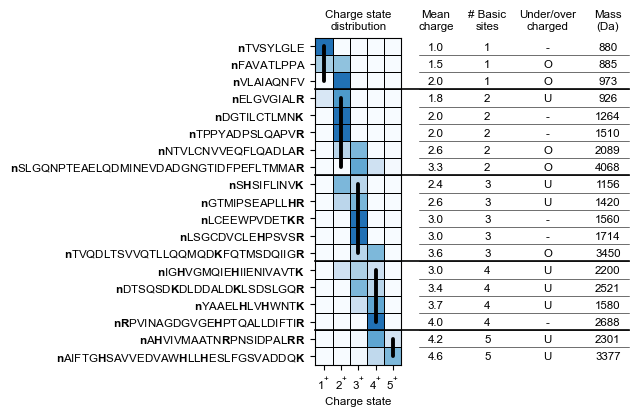

In [3]:
#%% Figure 1

run = '20210420_MJ_LFQ_Hela_standard_gradient_long_Voltage_2p5_01'

csd = csd_all[run]

sample_conditions = [
    (1, lambda d : not is_acetylated(d.name) and d[1] == 1),
    (1, lambda d : not is_acetylated(d.name) and d[1] > 0.2 and d[2] < 0.8),
    (1, lambda d : not is_acetylated(d.name) and d[2] == 1),
    (2, lambda d : d[1] > 0.2 and d[2] > 0.2),
    (2, lambda d : d[2] == 1),
    (2, lambda d : d[2] == 1),
    (2, lambda d : d[2] > 0.2 and d[3] > 0.2 and d[3] > d[2]),
    (2, lambda d : d[3] > 0.2 and d[4] > 0.2),
    (3, lambda d : d[2] > 0.2 and d[3] > 0.2),
    (3, lambda d : d[2] > 0.2 and d[3] > 0.2),
    (3, lambda d : d[3] == 1),
    (3, lambda d : d[3] == 1),
    (3, lambda d : d[3] > 0.2 and d[4] > 0.2 and d[4] > d[3]),
    (4, lambda d : d[2] > 0.2 and d[2] > 0.2),
    (4, lambda d : d[3] > 0.2 and d[4] > 0.2 and d[3] > d[4]),
    (4, lambda d : d[3] > 0.2 and d[4] > 0.2 and d[3] < d[4]),
    (4, lambda d : d[4] == 1),
    (5, lambda d : d[4] > 0.2 and d[5] > 0.2 and d[4] > d[5]),
    (5, lambda d : d[4] > 0.2 and d[5] > 0.2 and d[4] < d[5]),
    ]


np.random.seed(20230209)
peptides = []
for bsc, condition in sample_conditions:
    while True:
        i = np.random.randint(len(csd))
        peptide = csd.index[i]
        d = csd.iloc[i]
        
        if count_basic_sites(peptide) == bsc and condition(d):
            print(peptide)
            peptides.append(peptide)
            break


cmap = mc.ListedColormap(mpl.cm.get_cmap('Blues',1e5)(np.linspace(0,0.75,256)))

def adjust_lightness(color, amount=0.5):
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], max(0, min(1, amount * c[1])), c[2])


def adjust_color(color):
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hsv(*mc.to_rgb(c))
    return colorsys.hsv_to_rgb(c[0], 1, c[2])


basic_site_counts = count_basic_sites(peptides)
masses = peptide_monoiso_mass(peptides)
mean_charges = csd.loc[peptides] @ np.arange(1,6)
peptides = list(next(zip(*sorted(zip(peptides, basic_site_counts, mean_charges, masses), key=lambda x : (x[1], x[2]), reverse=True))))
 

mpl.rcParams['mathtext.fontset'] = 'custom'
mpl.rcParams['mathtext.bf'] = 'Arial:bold'


ax_width = 0.86
ax_height = ax_width * len(peptides) / 5

figsize = (10, 7)
plt.figure(figsize=figsize)
axsize = (ax_width, ax_height)
position = compute_axes_position(figsize, axsize, left=4, top=1, coords='margin')
plt.gcf().add_axes(position)
plt.gca().pcolormesh(csd.loc[peptides], cmap=cmap, edgecolors='k', linewidth=0.5)
plt.xticks(np.arange(5) + 0.5, [f'{k}' + '$^\mathdefault{+}$' for k in range(1,6)], fontsize=8.33)


def format_peptides(peptide):
    formatted_peptide = ['n'] + list(peptide.replace('camC', 'C'))

    basic_locs = [i for i, aa in enumerate(formatted_peptide) if aa in ['n', 'R', 'K', 'H']]
    
    for i in basic_locs:
        formatted_peptide[i] = r'$\bf{' + formatted_peptide[i] + r'}$'
        
    formatted_peptide = ''.join(formatted_peptide)
    return formatted_peptide

formatted_peptides = list(map(format_peptides, peptides))

plt.yticks(np.arange(len(peptides)) + 0.5, formatted_peptides, fontsize=8.33)
plt.xlabel('Charge state', fontsize=8.33)


left_margins = (7, 3, 3.5, 3.5)
left_spacings = np.cumsum(left_margins)

annotation_kwargs = {
    'xycoords' : 'data',
    'ha' : 'center',
    'va' : 'center_baseline',
    'annotation_clip' : False,
    'fontsize' : 8.33,
    }

text_table = []
for peptide in peptides:
    mean_charge = csd.loc[peptide] @ np.arange(1,6)
    bsc = count_basic_sites(peptide)
    charging_regime = 'O' if mean_charge > bsc else 'U' if mean_charge < bsc else '-'
    text_table.append(['%.1f' % mean_charge, str(bsc), charging_regime, int(peptide_monoiso_mass(peptide))])
text_table = np.array(text_table)

for j in range(text_table.shape[1]):
    for i in range(text_table.shape[0]):
        text = text_table[i, j]    
        plt.annotate(text, (left_spacings[j], i + 0.5), **annotation_kwargs)

titles = ['Mean\ncharge', '# Basic\nsites', 'Under/over\ncharged', 'Mass\n(Da)']

plt.annotate('Charge state\ndistribution', (2.5, len(peptides) + 0.5),  xycoords='data', ha='center', va='baseline', annotation_clip=False, fontsize=8.33)
for j, title in enumerate(titles):
    plt.annotate(
        title,
        (left_spacings[j], len(peptides) + 0.5),
        xycoords='data',
        ha='center',
        va='baseline',
        annotation_clip=False,
        fontsize=8.33
        )

hline_right_margin = 1.25

for i in range(1, len(peptides)):
    plt.axhline(
        i,
        xmin= (left_margins[0] - 1)/5,
        xmax= (sum(left_margins) + hline_right_margin)/5,
        clip_on=False,
        color='k',
        linewidth=0.4
        )
    
for i in range(1, len(peptides)):
    if count_basic_sites(peptides[i]) != count_basic_sites(peptides[i-1]):
        plt.axhline(
            i,
            xmin = 0,
            xmax = (sum(left_margins) + hline_right_margin)/5,
            clip_on=False,
            color='k',
            linewidth=1.2
            )

basic_site_counts = count_basic_sites(peptides)
for k in range(1,6):
    start, finish = np.where(basic_site_counts == k)[0][[0,-1]]
    plt.plot(
        (k - 0.5, k - 0.5),
        (start + 0.5, finish + 0.5),
        'k',
        solid_capstyle = 'round',
        linewidth = 0.8 * 3.5
        )    


plt.show()
setup_rcParams()


## Supplementary Figure 1, 2 <a name="suppfig12"></a>

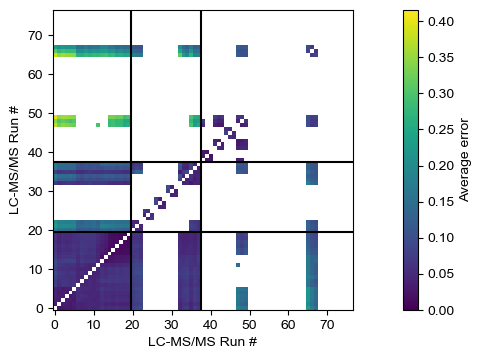

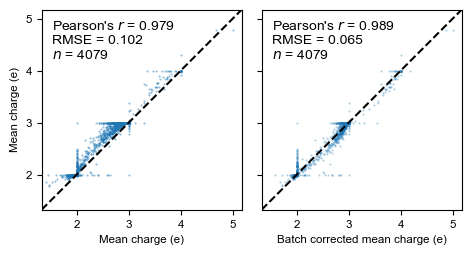

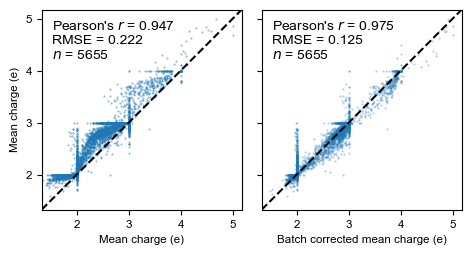

In [4]:
#%% Supplementary Figure 1, 2


group_to_runs = {
    'Ours' : lab_to_runs('Ours'),
    'Confetti' : lab_to_runs('Confetti'),
    'Meier' : MEIER_AGGREGATES
    }

run_to_group = { run : group for group, runs in group_to_runs.items() for run in runs }

runs = []
runs = list(itertools.chain.from_iterable(group_to_runs.values()))

num_peptides = np.zeros(len(runs))

mean_tv = np.zeros((len(runs), len(runs)))
num_intersect = np.zeros((len(runs), len(runs)))
batch_corrected_mean_tv = np.zeros((len(runs), len(runs)))
batch_parameter = np.zeros((len(runs), len(runs)))

for i,j in itertools.permutations(list(range(len(runs))), 2):
    csd_i = csd_all[runs[i]]
    csd_j = csd_all[runs[j]]
    peptides = csd_i.index.intersection(csd_j.index)
    csd_i = csd_i.loc[peptides]
    csd_j = csd_j.loc[peptides]
    
    if len(peptides) >= 200:
        mean_tv[i,j] = ((csd_i - csd_j).dropna().abs().sum(1)/2).mean()
        num_intersect[i,j] = len(peptides)
        
        def fun(b):
            temp = csd_j * b**np.arange(1,6)
            temp = temp.div(temp.sum(1), axis=0)
            return ((csd_i - temp).dropna().abs().sum(1)/2).mean()
        
        opt = scipy.optimize.minimize(fun, 1)
        batch_corrected_mean_tv[i,j] = opt.fun
        batch_parameter[i,j] = opt.x[0]
    else:
        mean_tv[i,j] = np.nan
        num_intersect[i,j] = np.nan
        batch_corrected_mean_tv[i,j] = np.nan
        batch_parameter[i,j] = np.nan
        
        
ax_width = 3
ax_height = 3
axsize = (ax_width, ax_height)

fig_width = ax_width + 3
fig_height = ax_height + 2
figsize = (fig_width, fig_height)

plt.figure(figsize = figsize)
position = compute_axes_position(figsize, axsize, left = 1, top = 1, coords='margin')
plt.gcf().add_axes(position)

plt.imshow(mean_tv * np.where(np.tril(np.ones(batch_corrected_mean_tv.shape), k=-1), 1, np.nan), origin='lower')
plt.clim([0, np.nanmax(mean_tv) * 1.05])

plt.imshow(batch_corrected_mean_tv * np.where(np.triu(np.ones(batch_corrected_mean_tv.shape), k=1), 1, np.nan), origin='lower')
plt.clim([0, np.nanmax(mean_tv) * 1.05])

plt.xlabel('LC-MS/MS Run #')
plt.ylabel('LC-MS/MS Run #')
plt.xticks(np.arange(0, len(runs), 10))
plt.yticks(np.arange(0, len(runs), 10))

for i in np.nonzero(np.ediff1d(pd.CategoricalIndex([run_to_group[run] for run in runs]).codes))[0]:
    plt.axvline(i+0.5, color='k')
    plt.axhline(i+0.5, color='k')
position = compute_axes_position(figsize, (0.05 * ax_width, ax_height), left = 1 + ax_width + 0.5, top = 1, coords='margin')
cax = plt.gcf().add_axes(position)
plt.colorbar(cax=cax)
plt.ylabel('Average error')
plt.show()
    

run_pairs = [
    (
        '20210801_MJ_HeLa_Thermo_15cm_flowrate_800nl_01',
        '20210801_MJ_HeLa_Thermo_15cm_flowrate_200nl_01',
    ),
    (
        '20210420_MJ_LFQ_Hela_standard_gradient_long_Voltage_2p5_01',
        'HeLa_try_HCD_3'
    ),
]

experiment_label = {
    '20210801_MJ_HeLa_Thermo_15cm_flowrate_200nl_01' : 'Ours; HeLa trypsin; 200 nL/min flow rate; Rep. 1',
    '20210801_MJ_HeLa_Thermo_15cm_flowrate_800nl_01' : 'Ours; HeLa trypsin; 800 nL/min flow rate; Rep. 1',
    '20210420_MJ_LFQ_Hela_standard_gradient_long_Voltage_2p5_01' : 'Ours; HeLa trypsin; 2.5 kV ESI voltage; Rep. 1',
    'HeLa_try_HCD_3' : 'Confetti; HeLa trypsin; Rep. 3',

}


for k, (run_i, run_j) in enumerate(run_pairs):
    
    csd_i = csd_all[run_i]
    csd_j = csd_all[run_j]
    peptides = csd_i.index.intersection(csd_j.index)
    csd_i = csd_i.loc[peptides]
    csd_j = csd_j.loc[peptides]
    mean_charge_i = csd_i @ np.arange(1,6)
    mean_charge_j = csd_j @ np.arange(1,6)
    
    
    def fun(b):
        temp = csd_j * b**np.arange(1,6)
        temp = temp.div(temp.sum(1), axis=0)
        return np.mean(((csd_i - temp).abs()).sum(1) / 2)
    
    b = scipy.optimize.minimize(fun, 1).x[0]
    
    ax_width = 2
    ax_height = 2
    axsize = (ax_width, ax_height)
    fig_width = 6
    fig_height = 6
    figsize = (fig_width, fig_height)
    plt.figure(figsize = figsize)
    position = compute_axes_position(figsize, axsize, left = 1, top = 1, coords='margin')
    ax = plt.gcf().add_axes(position)
    plt.sca(ax)
    
    plt.scatter(mean_charge_j, mean_charge_i, c='C0', s=0.25, alpha=0.5)
    plt.xticks(fontsize='small')
    plt.yticks(fontsize='small')
    plt.xlabel('Mean charge (e)', fontsize='small')
    plt.ylabel('Mean charge (e)', fontsize='small')
    plt.xlim(margined([1.5,5], 0.05))
    plt.ylim(margined([1.5,5], 0.05))
    x = mean_charge_j
    y = mean_charge_i
    plt.annotate(f'Pearson\'s $r$ = {np.corrcoef(x,y)[0][1]:.3f}\nRMSE = {np.sqrt(np.mean((x-y)**2)):.3f}\n$n$ = {len(x)}', (0.05,0.95), xycoords='axes fraction', va='top')
    set_axes_equal()

    position = compute_axes_position(figsize, axsize, left = 1 + ax_width + 0.2, top = 1, coords='margin')
    ax = plt.gcf().add_axes(position)
    plt.sca(ax)
    
    batch_corrected_csd_j = csd_j * b**np.arange(1,6)
    batch_corrected_csd_j = batch_corrected_csd_j.div(batch_corrected_csd_j.sum(1), axis=0)
    batch_corrected_mean_charge_j = batch_corrected_csd_j @ np.arange(1,6)
    plt.scatter(batch_corrected_mean_charge_j, mean_charge_i, c='C0', s=0.5, alpha=0.25)
    plt.xticks(fontsize='small')
    plt.yticks(fontsize='small')
    plt.gca().set_yticklabels([])
    plt.xlabel('Batch corrected mean charge (e)', fontsize='small')
    plt.xlim(margined([1.5,5], 0.05))
    plt.ylim(margined([1.5,5], 0.05))
    x = batch_corrected_mean_charge_j
    y = mean_charge_i
    plt.annotate(f'Pearson\'s $r$ = {np.corrcoef(x,y)[0][1]:.3f}\nRMSE = {np.sqrt(np.mean((x-y)**2)):.3f}\n$n$ = {len(x)}', (0.05,0.95), xycoords='axes fraction', va='top')
    set_axes_equal()
    plt.show()


# Section 2 <a name="section2"></a>

In [5]:
#%% Initialize Figure 2, Supplementary Figure 3,4

xlim = [500, 4800]

import matplotlib.colors as mc


def mean_charge_vs_mass_figure(run, mz_bounds):
    color_dict = {
        1 : 'C0',
        2 : 'C1',
        3 : 'C2',
        4 : 'C3',
        5 : 'C4'
        }
    
    
    cmap_dict_ = {
        'C0' : 'Blues',
        'C1' : 'Oranges',
        'C2' : 'Greens',
        'C3' : 'Reds',
        'C4' : 'Purples'
        }
    
    
    min_cmap = 0.2
    
    cmap_dict = { k : cmap_dict_[v] for k,v in color_dict.items()}
    cmap_dict = {
        k : mc.ListedColormap(mpl.cm.get_cmap(v,1e5)(np.linspace(min_cmap,1,256)))
        for k,v in cmap_dict.items()
        }
    
    
    np.random.seed(20230207)
    csd = csd_all[run]
    masses = peptide_monoiso_mass(csd.index)
    basic_site_counts = count_basic_sites(csd.index)
    jiggles = np.random.uniform(-1,1,len(csd.index)) * 0.02
    mean_charges = csd.to_numpy() @ np.arange(1,6)
        
    
    xticks = [1000,2000,3000,4000]
    xticklabels = ['1000', '', '3000', '']
    
    ylim_dict = {
        1 : [1,3.4],
        2 : [0.7,4.3],
        3 : [1.7,4.3],
        4 : [2.5,4.3],
        5 : [2.7,5.3],
        }
    
    ax_width = 1.5
    ytick_height = 1.2 / 3.6 * 0.8
    ax_between = 0.1 * 0.8
    
    hist_zorder = -999
    borderline_zorder = 1
    line_zorder = 2
    spine_zorder = 0
    cutoff_zorder = -1
    
    cbarsize = ( 0.3 * ax_width, 0.15 * ytick_height)
    cbar_bottom_margins = {
        5 : 0.7 * ytick_height,
        4 : 0.7 * ytick_height,
        3 : 0.7 * ytick_height,
        2 : 0.7 * ytick_height,
        1 : 0.7 * ytick_height,
        }
    
    
    figsize = (6,8)
    plt.figure(figsize=figsize)
    axes_dict = {}
    axsize_dict = {}
    cbar_axes_dict = {}
    top = 1
    
    for k in [1,2,3,4,5][::-1]:
        axsize = (ax_width, np.ptp(ylim_dict[k])*ytick_height)
        position = compute_axes_position(figsize, axsize, right=1, top=top, coords='margin')
        plt.gcf().add_axes(position)
        axsize_dict[k] = axsize
        axes_dict[k] = plt.gca()
        
        
        position = compute_axes_position(
            figsize,
            cbarsize,
            right= 1 + 0.05 * ax_width,
            top=top + axsize[1] - cbarsize[1] - cbar_bottom_margins[k],
            coords='margin'
            )
        plt.gcf().add_axes(position, zorder=999)
        cbar_axes_dict[k] = plt.gca()
        
        top += axsize[1] + ax_between
        
        
    for k in [1,2,3,4,5]:
        ax = axes_dict[k]
        ax.spines['right'].set_color('none')
        ax.spines['top'].set_color('none')
        ax.spines['bottom'].set_position(('data', k))
        ax.spines['bottom'].set_zorder(spine_zorder)
    
    for k in [2,3,4,5]:
        ax = axes_dict[k]
        plt.setp(ax.get_xticklabels(), visible=False)
        ax.xaxis.set_tick_params(length=0)
        
    for k in [1,2,3,4,5]:
        plt.sca(axes_dict[k])
        
        idx = basic_site_counts == k
        x = masses[idx]
        y = mean_charges[idx]
        
        binx = 40
        biny = int(binx * axsize_dict[k][1] / axsize_dict[k][0] / np.sqrt(3))
        
        plt.hexbin(x,y, gridsize=(binx, biny), cmap=cmap_dict[k], bins='log', linewidths=0, mincnt=0, zorder=hist_zorder)
        plt.clim([1,100])
    
        
        model = pygam.LinearGAM(terms=pygam.terms.s(0, lam=5, constraints='monotonic_inc'))
        model.fit(x, y)
        xx = np.linspace(*margined([min(x), max(x)], -0.05), 100)
        z = model.predict(xx)
        color = color_dict[k]
        color = darken_color(color_dict[k], 0.9)
        color = saturate_color(color, 0.5)
        plt.plot(xx[z < k], z[z < k], linestyle='-', color='w', linewidth=2, zorder=borderline_zorder)
        plt.plot(xx[z > k], z[z > k], linestyle='-', color='w', linewidth=2, zorder=borderline_zorder)
        plt.plot(xx[z < k], z[z < k], linestyle='--', color=color, linewidth=1, zorder=line_zorder)
        plt.plot(xx[z > k], z[z > k], linestyle='-', color=color, linewidth=1, zorder=line_zorder)
        
        plt.xlim(xlim)
        plt.ylim(ylim_dict[k])
        plt.xticks(xticks, xticklabels)
        
        plt.yticks(range(int(np.ceil(ylim_dict[k][0])), int(np.floor(ylim_dict[k][1])) + 1))
        
        plt.gca().set_yticklabels([
            str(int(label)) + '$^{\mathdefault{+}}$'
            for label in plt.gca().get_yticks()
            ])
        
        
    for k in [1,2,3,4,5]:
        plt.sca(cbar_axes_dict[k])
        mpl.colorbar.ColorbarBase(
            plt.gca(),
            cmap=cmap_dict[k],
            norm=mc.LogNorm(1,100),
            orientation='horizontal'
            )
        plt.xticks(
            [1,10,100],
            ['10$^\mathdefault{0}$','10$^\mathdefault{1}$','10$^\mathdefault{2}$'],
            fontsize='x-small',
            path_effects = [
                mpl.patheffects.withStroke(linewidth=2.0, foreground='w')
                ]
            )
        plt.gca().tick_params(axis='x', pad=2)
        
    mz_cutoff_kwargs = {
        'hatch' : '\\\\\\',
        'facecolor' : 'w',
        'edgecolor' : lighten_color('gray', 0.6),
        'linewidth' : 0.8,
        'zorder' : cutoff_zorder,
        }
    for ax in axes_dict.values():
        ax.fill_between(list(itertools.chain.from_iterable([[mz_bounds[0] * z - 0.01 * np.ptp(xlim), mz_bounds[0] * z - 0.01 * np.ptp(xlim)] for z in range(1,6)])), list(itertools.chain.from_iterable([[z-1, z] for z in range(1,6)])), 6, **mz_cutoff_kwargs)
        ax.fill_between(list(itertools.chain.from_iterable([[mz_bounds[1] * z - 0.01 * np.ptp(xlim), mz_bounds[1] * z - 0.01 * np.ptp(xlim)] for z in range(1,6)])), 0, list(itertools.chain.from_iterable([[z-1, z] for z in range(1,6)])), **mz_cutoff_kwargs)
    
    ax = axes_dict[1]
    ax.fill_between([xlim[0], xlim[1]], -1, 1, facecolor='w', linewidth=0, zorder=cutoff_zorder)
    ax.set_xlabel('Mass (Da)')
    
    axsize = (ax_width, sum([ np.ptp(ylim) * ytick_height + ax_between for ylim in ylim_dict.values()]) - ax_between)
    position = compute_axes_position(figsize, axsize, right=1, top=1, coords='margin')
    plt.gcf().add_axes(position, zorder=-999)
    
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.set_yticks(axes_dict[1].get_yticks())
    ax.set_yticklabels(axes_dict[1].get_yticklabels())
    ax.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
    plt.ylabel('Mean charge (e)', labelpad=6)
    
    plt.show()
    
    
    
    
    ax_height = (
        sum([
            np.ptp(ylim) * ytick_height + ax_between
            for ylim in ylim_dict.values()
            ])
        - ax_between
        )
    
    
    
    lighten_amount_dict = {
        1 : 0.4,
        2 : 0.4,
        3 : 0.4,
        4 : 0.4,
        5 : 0.4,
        }
    
    
    figsize = (6,8)
    axsize = (4, ax_height)
    plt.figure(figsize=figsize)
    position = compute_axes_position(figsize, axsize, left=1, top=1, coords='margin')
    plt.gcf().add_axes(position)
    
    for k in [1,2,3,4,5]:
        idx = basic_site_counts == k
        x = masses[idx]
        y = mean_charges[idx]
        j = jiggles[idx]
    
        plt.scatter(x[y <= k], (y + j)[y <= k], s=2, color=lighten_color(color_dict[k], lighten_amount_dict[k]), alpha=0.5, zorder=1 + 0.1*k)
        plt.scatter(x[y > k], (y + j)[y > k], s=2, color=lighten_color(color_dict[k], lighten_amount_dict[k]), alpha=0.5, zorder=2 - 0.1*k)
    
        model = pygam.LinearGAM(terms=pygam.terms.s(0, lam=5, constraints='monotonic_inc'))
        model.fit(x, y)
        xx = np.linspace(*margined([min(x), max(x)], -0.05), 100)
        z = model.predict(xx)
        color = darken_color(color_dict[k], 0.9)
        color = saturate_color(color, 0.5)
        plt.plot(xx[z < k], z[z < k], linestyle='-', color='w', linewidth=2, zorder=2)
        plt.plot(xx[z > k], z[z > k], linestyle='-', color='w', linewidth=2, zorder=2)
        plt.plot(xx[z < k], z[z < k], linestyle='--', color=color, linewidth=1, zorder=999)
        plt.plot(xx[z > k], z[z > k], linestyle='-', color=color, linewidth=1, zorder=999)
    
    plt.xlim(xlim)
    plt.xticks(xticks)
    plt.ylim([0.9,5.1])
    plt.yticks([1,2,3,4,5])
    
    plt.gca().fill_between(list(itertools.chain.from_iterable([[mz_bounds[0] * z - 0.01 * np.ptp(xlim), mz_bounds[0] * z - 0.01 * np.ptp(xlim)] for z in range(1,6)])), list(itertools.chain.from_iterable([[z-1, z] for z in range(1,6)])), 6, **mz_cutoff_kwargs)
    plt.gca().fill_between(list(itertools.chain.from_iterable([[mz_bounds[1] * z - 0.01 * np.ptp(xlim), mz_bounds[1] * z - 0.01 * np.ptp(xlim)] for z in range(1,6)])), 0, list(itertools.chain.from_iterable([[z-1, z] for z in range(1,6)])), **mz_cutoff_kwargs)
    plt.gca().set_yticklabels([
        str(int(label)) + '$^{\mathdefault{+}}$'
        for label in plt.gca().get_yticks()
        ])
    
    plt.xlabel('Mass (Da)')
    plt.ylabel('Mean charge (e)')
    
    plt.show()
    
    
    
    figsize = (2,2)
    axsize = (1, 1)
    left_margin = 0.5
    bottom_margin = 0.1
    plt.figure(figsize=figsize)
    position = compute_axes_position(figsize, axsize, bottom=bottom_margin, left=left_margin, coords='margin')
    plt.gcf().add_axes(position)
    plt.axis('off')
    
    
    patch_kwargs = {
        'linestyle' : '-',
        'edgecolor' : 'k',
        'linewidth' : 0.8
        }
    
    handles = [
        mpl.patches.Patch(
            facecolor=color_dict[k],
            label=f'{k} basic site' + ('s' if k > 1 else ''),
            **patch_kwargs
            )
        for k in [5,4,3,2,1]
        ]
    
    
    handles += [
        matplotlib.lines.Line2D([],[], color='k', linestyle=(0,(1.5,1)), label='undercharging'),
        matplotlib.lines.Line2D([],[], color='k', linestyle='-', label='overcharging'),
        ]
    leg = plt.legend(handles=handles, loc='lower left', framealpha=1, borderaxespad=0, handlelength=1.2, handleheight=0.5, fontsize='small')
    leg.get_frame().set_edgecolor('k')
    leg.get_frame().set_boxstyle('Square', pad=0)
    leg.get_frame().set_linewidth(0.8)
    plt.show()
    


## Figure 2 <a name="fig2"></a>

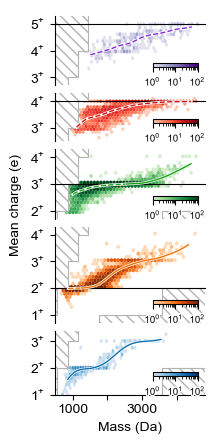

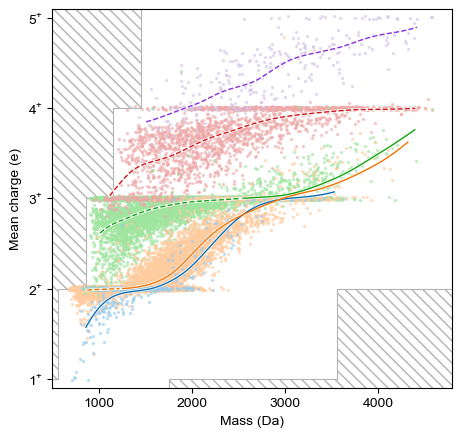

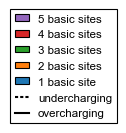

In [6]:
#%% Figure 2

run = '20210420_MJ_LFQ_Hela_standard_gradient_long_Voltage_2p5_01'
mz_bounds = mz_bounds_all[run]
mean_charge_vs_mass_figure(run, mz_bounds)


## Supplementary Figure 3 <a name="suppfig3"></a>

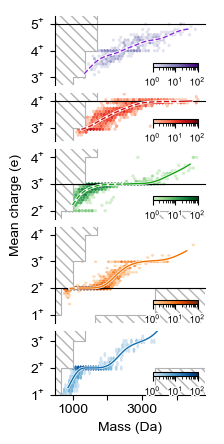

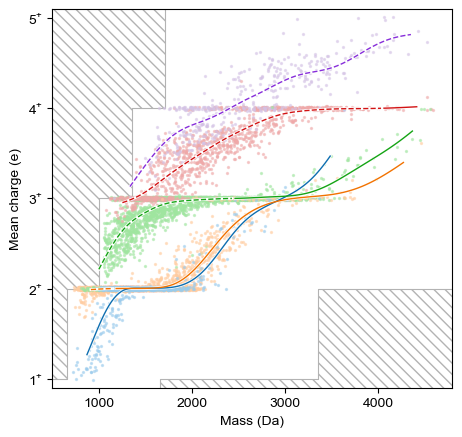

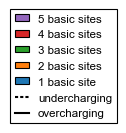

In [7]:
#%% Supplementary Figure 3

run = 'HeLa_GluC_HCD_1'
mz_bounds = mz_bounds_all[run]
mean_charge_vs_mass_figure(run, mz_bounds)


## Supplementary Figure 4 <a name="suppfig4"></a>

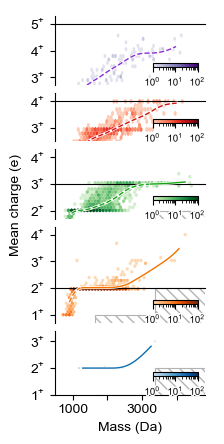

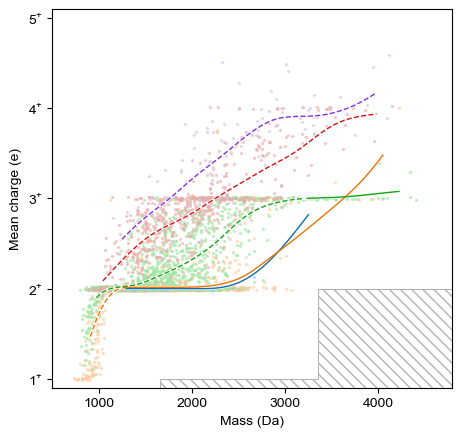

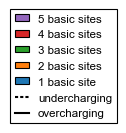

In [8]:
#%% Supplementary Figure 4

run = '20190504_TIMS1_FlMe_SA_HeLa_frac01_A10_1_93'
mz_bounds = mz_bounds_all[run]
mean_charge_vs_mass_figure(run, mz_bounds)

## Supplementary Figure 5 <a name="suppfig5"></a>

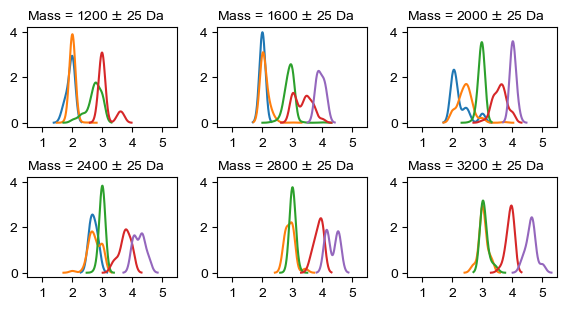

In [9]:
#%% Supplementary Figure 5


color_dict = {
    1 : 'C0',
    2 : 'C1',
    3 : 'C2',
    4 : 'C3',
    5 : 'C4',
    }

run = '20210420_MJ_LFQ_Hela_standard_gradient_long_Voltage_2p5_01'

csd = csd_all[run]
mean_charges = csd @ np.arange(1,6)
masses = peptide_monoiso_mass(csd.index)
basic_site_counts = count_basic_sites(csd.index)

left_margin = 1
top_margin = 1

axsize = (1.5,1)
ax_between_width = 0.4
ax_between_height = 0.5

figsize = (7,6)
plt.figure(figsize=figsize)

for k, mass_target in enumerate([1200, 1600, 2000, 2400, 2800, 3200]):
    mass_bin_width = 50
    
    mass_lb = mass_target - mass_bin_width / 2
    mass_ub = mass_target + mass_bin_width / 2
    idx0 = (masses > mass_lb) & (masses < mass_ub)
    
    nrow = 2
    ncol = 3
    
    i = k // ncol
    j = k % ncol
    
    
    left = left_margin + (axsize[0] + ax_between_width) * j
    top = top_margin + (axsize[1] + ax_between_height) * i
    
    plt.gcf().add_axes(compute_axes_position(figsize, axsize, left=left, top=top, coords='margin'))
    
    bw = 0.1
    binwidth = 1/8
    for bsc in [1,2,3,4,5]:
        idx = idx0 & (basic_site_counts == bsc)
        if sum(idx) > 1:
            sns.kdeplot(
                mean_charges[idx],
                weights = 1/sum(idx),
                color=color_dict[bsc],
                bw_method = bw*np.sqrt(1/np.cov(mean_charges[idx])),
                cut = 3
                )
    plt.annotate(f'Mass = {mass_target} $\pm$ 25 Da', (0.00, 1.05), xycoords='axes fraction', va='bottom')
    plt.xlim([0.5, 5.5])
    plt.xticks([1,2,3,4,5])
    plt.ylabel('')
    plt.ylim(margined([0,4], 0.05))
plt.show()


# Section 3 <a name="section3"></a>

In [10]:
#%% Initialize Figure 3b-e, Supplementary Figure 6

h2o_mass_ = 18.01056

aa_features = [
    'Q',
    'N',
    'A',
    'V',
    'I',
    'L',
    'F',
    'M',
    'Y',
    'W',
    'P',
    'G',
    'camC',
    'nemC',
    'S',
    'T',
    'R',
    'K',
    'H',
    'E',
    'D',
    ]

nt_features = list(map(lambda a : 'n' + a, aa_features))

FEATURES = aa_features + nt_features

def create_dataset(run, charging_region):
    csd = csd_all[run]
    charge = charging_region_charge[charging_region]   
    basic_site_count = charging_region_basic_site[charging_region]   
    idx = (count_basic_sites(csd.index) == basic_site_count)
    
    
    idx = idx & (csd[charge] + csd[charge - 1] > 0)
    idx = idx & ~is_modified(csd.index)    
    
    sequences = csd.index[idx]
    
    m = peptide_monoiso_mass(sequences)

    sequences_with_terminals = peptide_parse(sequences)
    
    
    for seq in sequences_with_terminals:
        if 'n' + seq[0] in FEATURES:
            seq.insert(0, 'n' + seq[0])
    max_len = max(map(len, sequences_with_terminals))
    padded_sequences = [seq + ['_'] * (max_len - len(seq)) for seq in sequences_with_terminals]
    pre_one_hot_sequences = list(map(list, padded_sequences))
    
    FEATURES_ = FEATURES + ['_']
    enc = OneHotEncoder(categories = [FEATURES_] * max_len)
    enc.fit(pre_one_hot_sequences)
    X = enc.transform(pre_one_hot_sequences)
    X = np.array(X.todense()).reshape(-1, max_len, len(FEATURES_))
    X = X[:,:,:-1] # Remove '_'
    keep_features = X.sum((0,1)) > 0
    X = X[:,:,keep_features]
    features = [ feature for feature, keep  in zip(FEATURES, keep_features) if keep ]
    
    y = csd[charge][idx].to_numpy()
    y = csd[charge][idx] / (csd[charge][idx] + csd[charge-1][idx])
    csd = csd[idx].to_numpy()
    
    np.random.seed(20220408)
    shuffle_idx = np.random.permutation(sum(idx))
    X = X[shuffle_idx]
    m = m[shuffle_idx]
    y = y[shuffle_idx]
    sequences = sequences[shuffle_idx]
    l = np.array(list(map(len, sequences)))
    csd = csd[shuffle_idx]
    
    output = {
        'features' : features,
        'X' : X,
        'y' : y,
        'm' : m,
        'l' : l,
        'sequences' : sequences,
        'csd' : csd
        }
    return output



L2_PARAMETER = 0.01



def create_dataset_macro(run, charging_region):
    global features, X, y, m, l, sequences, csd
    output = create_dataset(run, charging_region)
    features = output['features']
    X = output['X']
    y = output['y']
    m = output['m']
    l = output['l']
    sequences = output['sequences']
    csd = output['csd']
    

def fit_logistic_gam_model_macro(run, charging_region):
    global model, coef_dict, coef_features
    create_dataset_macro(run, charging_region)
    terms = functools.reduce(operator.add, [pygam.l(i, lam=L2_PARAMETER, penalties='l2') for i in range(X.shape[2])])
    model = pygam.LogisticGAM(terms)
    model._estimate_r2 = lambda *args, **kwargs : np.nan # Silences warnings that occur when calculating (post-training) statistics in `_estimate_r2', which is broken for LogisticGAM fitted with a `y' that's not boolean, due improper log likelihood calculations.
    model.fit(X.sum(1),y)
    coef_features = features + ['intercept']
    coefs = model.coef_
    coef_dict = { k : v for k,v in zip(coef_features, coefs) }
    
    
@functools.lru_cache(maxsize=1024)
def logistic_gam_model_coef(run, charging_region):
    fit_logistic_gam_model_macro(run, charging_region)
    return coef_dict


@functools.lru_cache(maxsize=1024)
def dataset_length(run, charging_region):
    create_dataset_macro(run, charging_region)
    nonpure_idx = (y > 0) & (y < 1)
    
    aa_feature_idx = [ i for i,feature in enumerate(features) if feature in aa_features ]
    assert len(aa_feature_idx) == sum(X[:,:,aa_feature_idx].sum((0,1)) > 0)

    return (
        sum(nonpure_idx),
        len(y),
        sum(X[nonpure_idx,:,:][:,:,aa_feature_idx].sum((0,1)) > 0),
        len(aa_feature_idx)
        )
    

## Figure 3a <a name="fig3a"></a>

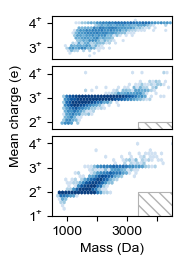

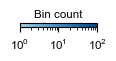

In [11]:
#%% Figure 3a 

fontsize = 'medium'

run = RUNS[4]
cmap_dict = {
    2 : 'Blues',
    3 : 'Blues',
    4 : 'Blues',
    }


min_cmap = 0.2
max_cmap = 0.95

cmap_dict = {
    k : mc.ListedColormap(mpl.cm.get_cmap(v,1e5)(np.linspace(min_cmap, max_cmap, 256)))
    for k,v in cmap_dict.items()
    }


np.random.seed(20230207)
csd = csd_all[run]
masses = peptide_monoiso_mass(csd.index)
basic_site_counts = count_basic_sites(csd.index)
jiggles = np.random.uniform(-1,1,len(csd.index)) * 0.02
mean_charges = csd.to_numpy() @ np.arange(1,6)
    

xticks = [1000,2000,3000,4000]
xticklabels = ['1000', '', '3000', '']
xlim = [500, 4500]
ylim_dict = {
    2 : [1,4.3],
    3 : [1.7,4.3],
    4 : [2.5,4.3],
    }


ytick_height = 1.2 / 3.6 * 0.8
ax_between = 0.1 * 0.8


scale = (0.24 * 2 / 1.992) / ytick_height

ytick_height *= scale
ax_between *= scale


ax_width = 1.2

hist_zorder = -999
borderline_zorder = 1
line_zorder = 2
spine_zorder = 0
cutoff_zorder = -1


figsize = (3,4)
plt.figure(figsize=figsize)
axes_dict = {}
axsize_dict = {}
top = 1

for k in [2,3,4][::-1]:
    axsize = (ax_width, np.ptp(ylim_dict[k])*ytick_height)
    position = compute_axes_position(figsize, axsize, left=1, top=top, coords='margin')
    plt.gcf().add_axes(position)
    axsize_dict[k] = axsize
    axes_dict[k] = plt.gca()
    top += axsize[1] + ax_between

for k in [3,4]:
    ax = axes_dict[k]
    
ax = axes_dict[2]
ax.spines['bottom'].set_position(('data', 1))
ax.spines['bottom'].set_zorder(spine_zorder)


for k in [3,4]:
    ax = axes_dict[k]
    plt.setp(ax.get_xticklabels(), visible=False)
    ax.xaxis.set_tick_params(length=0)
    
    
for k in [2,3,4]:
    plt.sca(axes_dict[k])
    
    idx = basic_site_counts == k
    x = masses[idx]
    y = mean_charges[idx]
    
    binx = int(40*scale)
    biny = int(binx * axsize_dict[k][1] / axsize_dict[k][0] / np.sqrt(3))
    
    plt.hexbin(x,y, gridsize=(binx, biny), cmap=cmap_dict[k], bins='log', linewidths=0, mincnt=0, zorder=hist_zorder)
    plt.clim([1,100])
    
    plt.xlim(xlim)
    plt.ylim(ylim_dict[k])
    plt.xticks(xticks, xticklabels, fontsize=fontsize)
    
    plt.yticks(range(int(np.ceil(ylim_dict[k][0])), int(np.floor(ylim_dict[k][1])) + 1))
    
    plt.gca().set_yticklabels([
        str(int(label)) + '$^{\mathdefault{+}}$'
        for label in plt.gca().get_yticks()
        ], fontsize=fontsize)
    
    
    
mz_cutoff_kwargs = {
    'hatch' : '\\\\\\',
    'facecolor' : 'w',
    'edgecolor' : lighten_color('gray', 0.6),
    'linewidth' : 0.8,
    'zorder' : cutoff_zorder,
    }
for ax in axes_dict.values():
    ax.fill_between(list(itertools.chain.from_iterable([[mz_bounds[0] * z - 0.01 * np.ptp(xlim), mz_bounds[0] * z - 0.01 * np.ptp(xlim)] for z in range(1,6)])), list(itertools.chain.from_iterable([[z-1, z] for z in range(1,6)])), 6, **mz_cutoff_kwargs)
    ax.fill_between(list(itertools.chain.from_iterable([[mz_bounds[1] * z - 0.01 * np.ptp(xlim), mz_bounds[1] * z - 0.01 * np.ptp(xlim)] for z in range(1,6)])), 0, list(itertools.chain.from_iterable([[z-1, z] for z in range(1,6)])), **mz_cutoff_kwargs)

ax = axes_dict[2]
ax.fill_between([xlim[0], xlim[1]], -1, 1, facecolor='w', linewidth=0, zorder=cutoff_zorder)
ax.set_xlabel('Mass (Da)', fontsize=fontsize)

axsize = (ax_width, sum([ np.ptp(ylim) * ytick_height + ax_between for ylim in ylim_dict.values()]) - ax_between)
position = compute_axes_position(figsize, axsize, left=1, top=1, coords='margin')
plt.gcf().add_axes(position, zorder=-999)

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_yticks(axes_dict[2].get_yticks())
ax.set_yticklabels(axes_dict[2].get_yticklabels())
ax.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.ylabel(
    'Mean charge (e)',
    fontsize=fontsize,
    )
plt.show()



for k in [1,2,3,4,5]:
    idx = basic_site_counts == k
    x = masses[idx]
    y = mean_charges[idx]

    model = pygam.LinearGAM(terms=pygam.terms.s(0, lam=5, constraints='monotonic_inc'))


plt.figure(figsize=(1,1))
a = np.array([[1,100]])
img = plt.imshow(a, cmap=mc.ListedColormap(mpl.cm.get_cmap(cmap_dict[2],1e5)(np.linspace(min_cmap, max_cmap, 256))), norm=mc.LogNorm(1,100))
plt.gca().set_visible(False)
plt.colorbar(location='bottom')
cax = plt.gca().images[-1].colorbar.ax
cax.set_xlabel('Bin count', fontsize='small')
cax.xaxis.set_label_position('top')
cax.set_xticks([1,10,100])
cax.set_xticklabels(['10$^\mathdefault{0}$','10$^\mathdefault{1}$','10$^\mathdefault{2}$'], fontsize='small')
plt.show()



## Figure 3b <a name="fig3b"></a>

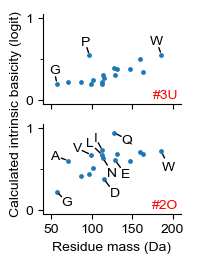

In [12]:
#%% Figure 3b

run = '20210420_MJ_LFQ_Hela_standard_gradient_long_Voltage_2p5_01'


L2_PARAMETER = 0.01


figsize = (4,4)
axsize = (1.25 * 1.1, (2 - 0.2) / 2)
ax_between = 0.2
position_0 = compute_axes_position(figsize, axsize, right=1, top=1, coords='margin')
position_1 = compute_axes_position(figsize, axsize, right=1, top=1 + axsize[1] + ax_between, coords='margin')

plt.figure(figsize=figsize)
axes = []
axes.append(plt.gcf().add_axes(position_0))
axes.append(plt.gcf().add_axes(position_1))

axes[0].annotate(
    '#3U',
    xy = (1, 0), xycoords='axes fraction',
    xytext = (-0.050 * 72 + 2, 0.050 * 72 - 2), textcoords='offset points',
    va = 'bottom',
    ha = 'right',
    color='red')

axes[1].annotate(
    '#2O',
    xy = (1, 0), xycoords='axes fraction',
    xytext = (-0.050 * 72 + 2, 0.050 * 72 - 2), textcoords='offset points',
    va = 'bottom',
    ha = 'right',
    color='red')




position = compute_axes_position(figsize, [axsize[0], ax_between + 2*axsize[1]], right=1, top=1, coords='margin')
ax = plt.gcf().add_axes(position)
ax.set_zorder(-999)
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(
    labelcolor='none',
    top=False, bottom=False, left=False, right=False
    )
plt.ylabel('Calculated intrinsic basicity (logit)', labelpad = -6)


axes[0].spines['top'].set_color('none')
axes[0].spines['right'].set_color('none')
axes[1].spines['top'].set_color('none')
axes[1].spines['right'].set_color('none')

charging_regions = ['2_over', '3_under']
relevant_aa_features = [aa for aa in aa_features if aa not in 'KRH']
for charging_region in charging_regions:
    
    if charging_region == '2_over':
        ax = axes[1]
    else:
        ax = axes[0]
    
    plt.sca(ax)
    
    ylim = [-0.05,1.05]
    xlim = [40,210]
    coef_dict = logistic_gam_model_coef(run, charging_region)
    n_nonpure, n, m_nonpure, m = dataset_length(run, charging_region)
    
    features = [ feature for feature in coef_dict if feature in relevant_aa_features ]
    
    coefs = np.array([ coef_dict[aa] for aa in features ])
    masses = [ peptide_monoiso_mass(aa) - h2o_mass for aa in features ] 
    plt.scatter(masses, coefs, s=6)

    features_ = features.copy()
    features_[features_.index('camC')] = 'C'
    xy_dict = {aa : (x,y) for aa, x, y in zip(features_, masses, coefs)}
    
    if charging_region == '2_over':
        aa_to_anotate = ['Q', 'N', 'I', 'L', 'V', 'A', 'G', 'W', 'D', 'E']
        xytext_offset_in = {}
        xytext_offset_in['Q'] = (0.074, -0.098) 
        xytext_offset_in['N'] = (0.044, -0.181)
        xytext_offset_in['I'] = (-0.085, 0.095) 
        xytext_offset_in['L'] = (-0.158, 0.085)
        xytext_offset_in['V'] = (-0.184, 0.034)
        xytext_offset_in['A'] = (-0.181, 0.018)
        xytext_offset_in['G'] = (0.045, -0.134)
        xytext_offset_in['W'] = (0.009, -0.183)
        xytext_offset_in['D'] = (0.059, -0.174)
        xytext_offset_in['E'] = (0.059, -0.174)
        
        shrinkA_dict = {}
        shrinkA_dict['Q'] = 5
        shrinkA_dict['N'] = 7
        shrinkA_dict['I'] = 4
        shrinkA_dict['L'] = 5
        shrinkA_dict['V'] = 4
        shrinkA_dict['A'] = 5
        shrinkA_dict['G'] = 5.5
        shrinkA_dict['W'] = 7
        shrinkA_dict['D'] = 6.5
        shrinkA_dict['E'] = 6.5
        
    if charging_region == '3_under':
        aa_to_anotate = ['P', 'G', 'W']
        xytext_offset_in = {}
        xytext_offset_in['P'] = (-0.087, 0.100)
        xytext_offset_in['G'] = (-0.081, 0.100)
        xytext_offset_in['W'] = (-0.114, 0.106)
        
        
        shrinkA_dict = {}
        shrinkA_dict['P'] = 4
        shrinkA_dict['G'] = 4.5
        shrinkA_dict['W'] = 5
        
        
    xytext_dict = {
        aa : np.array(xy_dict[aa]) + (offset[0] / axsize[0] * np.ptp(xlim), offset[1] / axsize[1] * np.ptp(ylim)) \
        for aa, offset in xytext_offset_in.items()
        }
    
    

    for aa in aa_to_anotate:
        xy = xy_dict[aa]
        xytext = xytext_dict[aa]
        shrinkA = shrinkA_dict[aa]
        plt.annotate(
            aa, xy = xy,
            xytext = xytext,
            horizontalalignment='left', verticalalignment='baseline',
            arrowprops=dict(
                arrowstyle = '-',
                facecolor='black',
                connectionstyle = 'arc3',
                patchA = None,
                shrinkA = shrinkA,
                shrinkB = 2,
                )
            )
    
    plt.xlim(xlim)
    plt.xticks([50,100,150,200])
    if charging_region == '3_under':
        plt.xticks([50,100,150,200], labels=['','','',''])
    else:
        plt.xlabel('Residue mass (Da)')
    plt.ylim(ylim)
        
    plt.gca().yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.5))
    plt.gca().yaxis.set_major_locator(mpl.ticker.MultipleLocator(1))
    


## Figure 3c <a name="fig3c"></a>

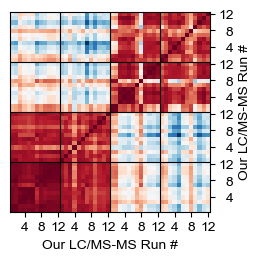

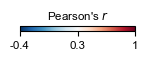

In [13]:
#%% Figure 3c

runs = lab_to_runs('Ours')

charging_regions = ['2_over', '3_over', '3_under', '4_under']



num_datapoints = []    
for run in runs:
    min_n_nonpure = np.inf
    min_n = np.inf
    for charging_region in charging_regions:
        n_nonpure, n, m_nonpure, m = dataset_length(run, charging_region)
        min_n_nonpure = min(min_n_nonpure, n_nonpure)
        min_n = min(min_n, n)
        max_char = 50
        
    num_datapoints.append(min_n_nonpure)

runs = [run for run, num in zip(runs, num_datapoints) if num > 100 ]



intrinsic_basicity_data = []
relevant_aa_features = list(aa_features)
relevant_aa_features.remove('R')
relevant_aa_features.remove('H')
relevant_aa_features.remove('K')
relevant_aa_features.remove('nemC')

for charging_region in charging_regions:
    for run in runs:
        try:
            n_nonpure, n, m_nonpure, m = dataset_length(run, charging_region)

            if n_nonpure > 100:
                coef_dict = logistic_gam_model_coef(run, charging_region)
                intrinsic_basicity_data.append([coef_dict[aa] for aa in relevant_aa_features if aa not in 'RKH'])
        except KeyboardInterrupt:
            break
        except:
            raise Exception()
intrinsic_basicity_data = np.array(intrinsic_basicity_data)





figsize = (4,4)
axsize = (2,2)
rect = compute_axes_position(figsize, axsize, right=1, top=1, coords='margin')

fig = plt.figure(figsize = figsize)
ax = fig.add_axes(rect)

plt.imshow(np.corrcoef(intrinsic_basicity_data), cmap='RdBu_r', origin='lower', interpolation='none')

plt.clim([-0.4,1])
tickpositions = [3,7,11]
ticklabels = ['4','8','12']
plt.xticks((np.array(tickpositions) + np.arange(4).reshape(-1,1)*len(runs)).flatten(), ticklabels*4)
plt.yticks((np.array(tickpositions) + np.arange(4).reshape(-1,1)*len(runs)).flatten(), ticklabels*4,
            ha='right'
           )
plt.tick_params(axis='y', pad=3.5 + 0.13936 * 72)
plt.gca().yaxis.set_label_position('right')
plt.gca().yaxis.tick_right()
plt.xlabel('Our LC/MS-MS Run #')
plt.ylabel('Our LC/MS-MS Run #')
for i in len(runs) * np.arange(1,4) - 0.5:    
    plt.axvline(i, color='k', linewidth=0.8)
    plt.axhline(i, color='k', linewidth=0.8)
plt.show()


plt.figure(figsize=(2,0.5))
a = np.array([[-0.4,1]])
img = plt.imshow(a, cmap='RdBu_r')
plt.gca().set_visible(False)
plt.colorbar(location='bottom')
cax = plt.gca().images[-1].colorbar.ax
cax.set_xlabel('Pearson\'s $r$', fontsize='small')
cax.xaxis.set_label_position('top')
cax.set_xticks([-0.4,0.3,1])
cax.set_xticklabels([-0.4,0.3,1], fontsize='small')
plt.show()





## Figure 3d,e <a name="fig3de"></a>

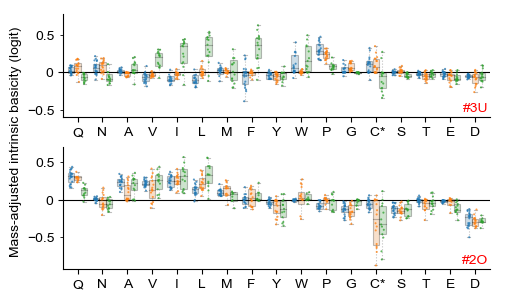

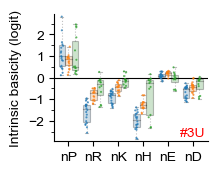

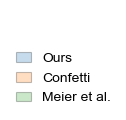

In [14]:
#%% Figure 3d,e

np.random.seed(20230314)

groups = {
    'Ours' : lab_to_runs('Ours'),
    'Confetti' : lab_to_runs('Confetti'),
    'Meier' : (
        []
        + MEIER_AGGREGATES
        )
    }

runs = list(itertools.chain.from_iterable(groups.values()))


L2_PARAMETER = 0.01

charging_regions = ['2_over', '3_under']

coef_features = aa_features + nt_features

coef_df = []
for charging_region in charging_regions:
    for run in runs:
        try:
            n_nonpure, n, m_nonpure, m = dataset_length(run, charging_region)
            if n_nonpure > 100:
                coef_dict = logistic_gam_model_coef(run, charging_region)
                coef_df.extend([(run, charging_region, feature, coef) for feature, coef in coef_dict.items()])
        except:
            pass
coef_df = pd.DataFrame(coef_df, columns=['run', 'charging_region', 'feature', 'coef'])
coef_df['group'] = None
for group_name, group in groups.items():
    coef_df.loc[coef_df['run'].isin(group), 'group'] = group_name



tol = 1e-8
def fit(X, params):
    return X.dot(params)

def cost_function(params, X, y, delta=0.01):
    return np.sum(scipy.special.huber(delta, y - fit(X, params)))

        

for charging_region, run in coef_df.set_index(['charging_region', 'run']).index.unique():
    idx = (coef_df['charging_region'] == charging_region) & (coef_df['run'] == run)
    coef_dict = coef_df[idx].set_index('feature')['coef']
    
    features = list( set(coef_dict.keys()) & set(aa_features) )
    features.remove('R')
    features.remove('K')
    features.remove('H')
    
    coefs = np.array([coef_dict[feature] for feature in features])
    masses = np.array([ peptide_monoiso_mass(feature) - h2o_mass_ for feature in features ])
    perp_coefs = coefs.copy()
    intercept, mass_coef = scipy.optimize.minimize(cost_function, [0, 0], args=(np.stack([np.ones(len(masses)), masses], axis=1), perp_coefs), tol=tol).x
    perp_coefs -= intercept + mass_coef * masses

    coefs_correction = { feature : correction for feature, correction in zip(features, coefs - perp_coefs) }
    coef_df.loc[idx, 'adjusted_coef'] = coef_df[idx].apply(lambda x : x['coef'] - coefs_correction[x['feature']] if x['feature'] in features else x['coef'], axis=1)




coef_df_ = coef_df.copy()
coef_df_.loc[coef_df_['feature'] == 'camC', 'feature'] = 'C'
coef_df_.loc[coef_df_['feature'] == 'nemC', 'feature'] = 'C'
relevant_features = ['Q', 'N', 'A', 'V', 'I', 'L', 'M', 'F', 'Y', 'W', 'P', 'G', 'C', 'S', 'T', 'R', 'K', 'H', 'E', 'D']
relevant_features.remove('R')
relevant_features.remove('K')
relevant_features.remove('H')


xlim = [-0.6, len(relevant_features) - 1+ 0.6]

ylabel = ''



lab_order = ['Ours', 'Confetti', 'Meier']

boxplot_kwargs = {
    'showfliers' : False,
    'linewidth' : 0.8,
    'boxprops' : {
        'edgecolor' : 'k',
        'alpha' : 0.25,
        },
    'whiskerprops' : {
        'linestyle' : ':',
        'color' : 'k',
        'alpha' : 0.25,
        },
    'capprops' : {
        'color' : 'k',
        'alpha' : 0.25,
        },
    'medianprops' : {
        'color' : 'k',
        'alpha' : 0.25,
        },
    }


hline_kwargs = {
    'color' : 'k',
    'linestyle' : '-',
    'linewidth' : 0.8,
    'zorder' : -999
    }


categorical_scatterplot = sns.stripplot


categorical_scatterplot_kwargs = {
    'alpha' : 0.75,
    'jitter' : 1/6,
    's' : 1.5,
    'dodge' : True,
    }

def remove_outliers_helper(df, value_label):
    return df.groupby(['feature', 'group'])[value_label].apply(np.array).apply(
        lambda x : x[
            (x <= np.quantile(x, 0.75) + 1.5*np.ptp(np.quantile(x, [0.25, 0.75]))) &
            (x >= np.quantile(x, 0.25) - 1.5*np.ptp(np.quantile(x, [0.25, 0.75])))
            ]
        ).reset_index().explode(value_label)



ytick_height = 0.75
ylims = [
    [-0.6, 0.775],
    [-0.925, 0.7],
    ]
ax_width = 4.275

figsize = (6, 6)
axsizes = [ (ax_width, ytick_height * np.ptp(ylim)) for ylim in ylims ]
fig_width, fig_height = figsize
ax_between = 0.3
bottom_margin = 1.3
left_margin = 1
axes = []
plt.figure(figsize=figsize)
position = compute_axes_position(figsize, axsizes[0], bottom=bottom_margin + axsizes[1][1] + ax_between, left=left_margin, coords='margin')
plt.gcf().add_axes(position)
axes.append(plt.gca())
position = compute_axes_position(figsize, axsizes[1], bottom=bottom_margin, left=left_margin, coords='margin')
plt.gcf().add_axes(position)
axes.append(plt.gca())

axes[0].spines['top'].set_color('none')
axes[0].spines['right'].set_color('none')
axes[1].spines['top'].set_color('none')
axes[1].spines['right'].set_color('none')


axes[0].annotate(
    '#3U',
    xy = (1, 0), xycoords='axes fraction',
    xytext = (-0.050 * 72 + 2, 0.050 * 72 - 2), textcoords='offset points',
    va = 'bottom',
    ha = 'right',
    color='red')

axes[1].annotate(
    '#2O',
    xy = (1, 0), xycoords='axes fraction',
    xytext = (-0.050 * 72 + 2, 0.050 * 72 - 2), textcoords='offset points',
    va = 'bottom',
    ha = 'right',
    color='red')

charging_region = '3_under'
g = sns.boxplot(
    data = coef_df_[(coef_df_['charging_region'] == charging_region) & coef_df_['feature'].isin(relevant_features)],
    x = 'feature',
    y = 'adjusted_coef',
    hue = 'group',
    orient = 'v',
    order = relevant_features,
    hue_order = lab_order,
    ax = axes[0],
    **boxplot_kwargs
    )
g.legend_.remove()



g = categorical_scatterplot(
    data = remove_outliers_helper(coef_df_[(coef_df_['charging_region'] == charging_region) & coef_df_['feature'].isin(relevant_features)],'adjusted_coef'),
    x = 'feature',
    y = 'adjusted_coef',
    hue = 'group',
    orient = 'v',
    order = relevant_features,
    hue_order = lab_order,
    ax = axes[0],
    **categorical_scatterplot_kwargs
    )
g.legend_.remove()

axes[0].axhline(0, **hline_kwargs)
axes[0].set_xlim(xlim)
axes[0].set_ylim(ylims[0])
axes[0].set_ylabel(ylabel)
axes[0].set_xlabel('')
xticklabels = list(relevant_features)
xticklabels[xticklabels.index('C')] = ' C*'
axes[0].set_xticklabels(xticklabels)
axes[0].yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.5))
axes[0].yaxis.set_major_locator(mpl.ticker.MultipleLocator(1))
axes[0].yaxis.set_minor_formatter(
    axes[0].yaxis.get_major_formatter()
    )


charging_region = '2_over'
g = sns.boxplot(
    data = coef_df_[(coef_df_['charging_region'] == charging_region) & coef_df_['feature'].isin(relevant_features)],
    x = 'feature',
    y = 'adjusted_coef',
    hue = 'group',
    orient = 'v',
    order = relevant_features,
    hue_order = lab_order,
    ax = axes[1],
    **boxplot_kwargs
    )
g.legend_.remove()

g = categorical_scatterplot(
    data = remove_outliers_helper(coef_df_[(coef_df_['charging_region'] == charging_region) & coef_df_['feature'].isin(relevant_features)],'adjusted_coef'),
    x = 'feature',
    y = 'adjusted_coef',
    hue = 'group',
    orient = 'v',
    order = relevant_features,
    hue_order = lab_order,
    ax = axes[1],
    **categorical_scatterplot_kwargs
    )
g.legend_.remove()

axes[1].axhline(0, **hline_kwargs)
axes[1].set_xlim(xlim)
axes[1].set_ylim(ylims[1])
axes[1].set_ylabel(ylabel)
axes[1].set_xlabel('')
xticklabels = list(relevant_features)
xticklabels[xticklabels.index('C')] = ' C*'
axes[1].set_xticklabels(xticklabels)
axes[1].yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.5))
axes[1].yaxis.set_major_locator(mpl.ticker.MultipleLocator(1))
axes[1].yaxis.set_minor_formatter(
    axes[1].yaxis.get_major_formatter()
    )


position = compute_axes_position(figsize, (axsizes[0][0], axsizes[0][1] + axsizes[1][1] + ax_between), bottom=bottom_margin, left=left_margin, coords='margin')
ax = plt.gcf().add_axes(position, zorder=-999)
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)

plt.ylabel('Mass-adjusted intrinsic basicity (logit)', labelpad=8)

plt.show()

    


coef_df_ = coef_df.copy()
coef_df_.loc[coef_df_['feature'] == 'camC', 'feature'] = 'C'
coef_df_.loc[coef_df_['feature'] == 'nemC', 'feature'] = 'C'

relevant_nt_features = ['nP', 'nR', 'nK', 'nH', 'nE', 'nD']
charging_region = '3_under'

xlim = [-0.6, len(relevant_nt_features)-1 + 0.6]
ylim = [-2.95, 2.95]
yticks = [-2, 0, 2]


plt.figure(figsize=figsize)
axes = []
axes.append(None)
ax_height = 1.275
position = compute_axes_position(figsize, (ax_width * (len(relevant_nt_features) + 0.2) / (len(relevant_features) + 0.2), ax_height), bottom=bottom_margin, left=left_margin, coords='margin')
plt.gcf().add_axes(position)
axes.append(plt.gca())

axes[1].spines['top'].set_color('none')
axes[1].spines['right'].set_color('none')
axes[1].annotate(
    '#3U',
    xy = (1, 0), xycoords='axes fraction',
    xytext = (-0.050 * 72 + 2, 0.050 * 72 - 2), textcoords='offset points',
    va = 'bottom',
    ha = 'right',
    color='red'
    )


g = sns.boxplot(
    data = coef_df_[(coef_df_['charging_region'] == charging_region) & coef_df_['feature'].isin(relevant_nt_features)],
    x = 'feature',
    y = 'coef',
    hue = 'group',
    orient = 'v',
    order = relevant_nt_features,
    hue_order = lab_order,
    ax = axes[1],
    **boxplot_kwargs
    )
g.legend_.remove()

g = categorical_scatterplot(
    data = remove_outliers_helper(coef_df_[(coef_df_['charging_region'] == charging_region) & coef_df_['feature'].isin(relevant_nt_features)],'coef'),
    x = 'feature',
    y = 'coef',
    hue = 'group',
    orient = 'v',
    order = relevant_nt_features,
    hue_order = lab_order,
    ax = axes[1],
    **categorical_scatterplot_kwargs
    )
g.legend_.remove()


axes[1].axhline(0, **hline_kwargs)
axes[1].set_xlim(xlim)
axes[1].set_ylim(ylim)
axes[1].set_yticks(yticks)
axes[1].yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.5))
axes[1].yaxis.set_major_locator(mpl.ticker.MultipleLocator(1))
axes[1].set_xlabel('')
axes[1].set_ylabel('Intrinsic basicity (logit)')
plt.show()


figsize = (2.5,2)
axsize = (1, 1)
left_margin = 1
bottom_margin = 0.1
plt.figure(figsize=figsize)
position = compute_axes_position(figsize, axsize, bottom=bottom_margin, left=left_margin, coords='margin')
plt.gcf().add_axes(position)
plt.axis('off')
handles = []
patch_kwargs = {
    'linestyle' : '-',
    'edgecolor' : 'k',
    'linewidth' : boxplot_kwargs['linewidth'],
    'alpha' : boxplot_kwargs['boxprops']['alpha'],
    }

handles.append(mpl.patches.Patch(facecolor='C0', label='Ours', **patch_kwargs))
handles.append(mpl.patches.Patch(facecolor='C1', label='Confetti', **patch_kwargs))
handles.append(mpl.patches.Patch(facecolor='C2', label='Meier et al.', **patch_kwargs))
leg = plt.legend(handles=handles, loc='lower left', framealpha=1, borderaxespad=0, handlelength=1.1, handleheight=0.7)
leg.get_frame().set_edgecolor('none')
leg.get_frame().set_facecolor('none')
leg.get_frame().set_boxstyle('Square', pad=0)
leg.get_frame().set_linewidth(0.)
plt.show()

## Supplementary Figure 6 <a name="suppfig6"></a>

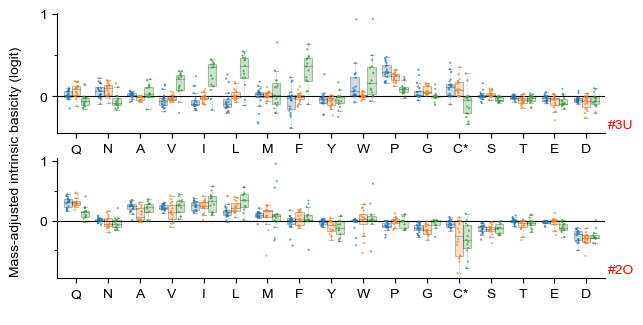

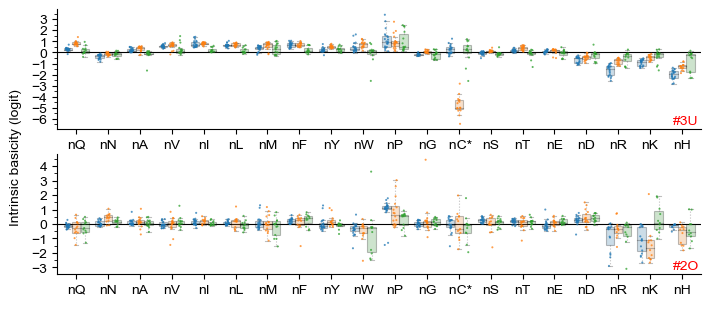

In [15]:
#%% Supplementary Figure 6

np.random.seed(20230314)

categorical_scatterplot = sns.stripplot

s_dict = {
    '3_under' : 1.5,
    '2_over' : 1.5,
    }

plot_kwargs = {
    'alpha' : 0.75,
    'jitter' : 1/6,
    }


coef_df_ = coef_df.copy()
coef_df_.loc[coef_df_['feature'] == 'camC', 'feature'] = 'C'
coef_df_.loc[coef_df_['feature'] == 'nemC', 'feature'] = 'C'


relevant_features = ['Q', 'N', 'A', 'V', 'I', 'L', 'M', 'F', 'Y', 'W', 'P', 'G', 'C', 'S', 'T', 'R', 'K', 'H', 'E', 'D']
relevant_features.remove('R')
relevant_features.remove('K')
relevant_features.remove('H')

boxplot_kwargs_ = boxplot_kwargs.copy()
boxplot_kwargs_['boxprops']['alpha'] = 0.25
boxplot_kwargs_['whiskerprops']['alpha'] = 0.25
boxplot_kwargs_['medianprops']['alpha'] = 0.25
boxplot_kwargs_['capprops']['alpha'] = 0.25



xlim = [-0.6, len(relevant_features) - 1+ 0.6]

ylabel = ''

hline_kwargs = {
    'color' : 'k',
    'linestyle' : '-',
    'linewidth' : 0.8,
    'zorder' : -999
    }

figsize = (8, 4)
axsize = (6.44 / (20 + 0.2) * (17+0.2), 1.2)
fig_width, fig_height = figsize
ax_width, ax_height = axsize
ax_between = 0.25
bottom_margin = 1.3
left_margin = 1
axes = []
plt.figure(figsize=figsize)
position = compute_axes_position(figsize, axsize, bottom=bottom_margin + ax_height + ax_between, left=left_margin, coords='margin')
plt.gcf().add_axes(position)
axes.append(plt.gca())
position = compute_axes_position(figsize, axsize, bottom=bottom_margin, left=left_margin, coords='margin')
plt.gcf().add_axes(position)
axes.append(plt.gca())
position = compute_axes_position(figsize, (axsize[0], 2*axsize[1] + ax_between), top = 0.2, left = 1, coords='margin')
ax = plt.gcf().add_axes(position, zorder=-999)
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.ylabel('Mass-adjusted intrinsic basicity (logit)')

axes[0].spines['top'].set_color('none')
axes[0].spines['right'].set_color('none')
axes[1].spines['top'].set_color('none')
axes[1].spines['right'].set_color('none')


axes[0].annotate(
    '#3U',
    xy = (1, 0), xycoords='axes fraction',
    xytext = (-(-0.050 * 72 + 2), 0.050 * 72 - 2), textcoords='offset points',
    va = 'bottom',
    ha = 'left',
    color='red')

axes[1].annotate(
    '#2O',
    xy = (1, 0), xycoords='axes fraction',
    xytext = (-(-0.050 * 72 + 2), 0.050 * 72 - 2), textcoords='offset points',
    va = 'bottom',
    ha = 'left',
    color='red')


charging_region = '3_under'
g = sns.boxplot(
    data = coef_df_[(coef_df_['charging_region'] == charging_region) & coef_df_['feature'].isin(relevant_features)],
    x = 'feature',
    y = 'adjusted_coef',
    hue = 'group',
    orient = 'v',
    order = relevant_features,
    ax = axes[0],
    **boxplot_kwargs_,
    )
g.legend_.remove()

g = categorical_scatterplot(
    data = coef_df_[(coef_df_['charging_region'] == charging_region) & coef_df_['feature'].isin(relevant_features)],
    x = 'feature',
    y = 'adjusted_coef',
    hue = 'group',
    orient = 'v',
    order = relevant_features,
    ax = axes[0],
    dodge=True,
    s=s_dict[charging_region],
    **plot_kwargs
    )
g.legend_.remove()
axes[0].axhline(0, **hline_kwargs)
axes[0].set_xlim(xlim)
axes[0].set_ylabel(ylabel)
axes[0].yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.5))
axes[0].yaxis.set_major_locator(mpl.ticker.MultipleLocator(1))
axes[0].set_xlabel('')
xticklabels = list(relevant_features)
xticklabels[xticklabels.index('C')] = ' C*'
axes[0].set_xticklabels(xticklabels)

charging_region = '2_over'

g = sns.boxplot(
    data = coef_df_[(coef_df_['charging_region'] == charging_region) & coef_df_['feature'].isin(relevant_features)],
    x = 'feature',
    y = 'adjusted_coef',
    hue = 'group',
    orient = 'v',
    order = relevant_features,
    ax = axes[1],
    **boxplot_kwargs_,
    )
g.legend_.remove()

g = categorical_scatterplot(
    data = coef_df_[(coef_df_['charging_region'] == charging_region) & coef_df_['feature'].isin(relevant_features)],
    x = 'feature',
    y = 'adjusted_coef',
    hue = 'group',
    orient = 'v',
    order = relevant_features,
    ax = axes[1],
    dodge=True,
    s=s_dict[charging_region],
    **plot_kwargs
    )
g.legend_.remove()
axes[1].axhline(0, **hline_kwargs)
axes[1].set_xlim(xlim)
axes[1].set_ylabel(ylabel)
axes[1].yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.5))
axes[1].yaxis.set_major_locator(mpl.ticker.MultipleLocator(1))
axes[1].set_xlabel('')
xticklabels = list(relevant_features)
xticklabels[xticklabels.index('C')] = ' C*'
axes[1].set_xticklabels(xticklabels)

plt.show()





coef_df_ = coef_df.copy()
coef_df_.loc[coef_df_['feature'] == 'ncamC', 'feature'] = 'nC'
coef_df_.loc[coef_df_['feature'] == 'nnemC', 'feature'] = 'nC'

relevant_nt_features = ['nQ', 'nN', 'nA', 'nV', 'nI', 'nL', 'nM', 'nF', 'nY', 'nW', 'nP', 'nG', 'nC', 'nS', 'nT', 'nE', 'nD', 'nR','nK','nH']



xlim = [-0.6, len(relevant_nt_features) - 1+ 0.6]

ylabel = ''

hline_kwargs = {
    'color' : 'k',
    'linestyle' : '-',
    'linewidth' : 0.8,
    'zorder' : -999
    }

figsize = (8, 4)
axsize = (6.44, 1.2)
fig_width, fig_height = figsize
ax_width, ax_height = axsize
ax_between = 0.25
bottom_margin = 1.3
left_margin = 1
axes = []
plt.figure(figsize=figsize)
position = compute_axes_position(figsize, axsize, bottom=bottom_margin + ax_height + ax_between, left=left_margin, coords='margin')
plt.gcf().add_axes(position)
axes.append(plt.gca())
position = compute_axes_position(figsize, axsize, bottom=bottom_margin, left=left_margin, coords='margin')
plt.gcf().add_axes(position)
axes.append(plt.gca())
position = compute_axes_position(figsize, (axsize[0], 2*axsize[1] + ax_between), top = 0.2, left = 1, coords='margin')
ax = plt.gcf().add_axes(position, zorder=-999)
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.ylabel('Intrinsic basicity (logit)')

axes[0].spines['top'].set_color('none')
axes[0].spines['right'].set_color('none')
axes[1].spines['top'].set_color('none')
axes[1].spines['right'].set_color('none')

axes[0].annotate(
    '#3U',
    xy = (1, 0), xycoords='axes fraction',
    xytext = (-0.050 * 72 + 2, 0.050 * 72 - 2), textcoords='offset points',
    va = 'bottom',
    ha = 'right',
    color='red')

axes[1].annotate(
    '#2O',
    xy = (1, 0), xycoords='axes fraction',
    xytext = (-0.050 * 72 + 2, 0.050 * 72 - 2), textcoords='offset points',
    va = 'bottom',
    ha = 'right',
    color='red')




charging_region = '3_under'

g = sns.boxplot(
    data = coef_df_[(coef_df_['charging_region'] == charging_region) & coef_df_['feature'].isin(relevant_nt_features)],
    x = 'feature',
    y = 'coef',
    hue = 'group',
    orient = 'v',
    order = relevant_nt_features,
    ax = axes[0],
    **boxplot_kwargs_,
    )
g.legend_.remove()

g = categorical_scatterplot(
    data = coef_df_[(coef_df_['charging_region'] == charging_region) & coef_df_['feature'].isin(relevant_nt_features)],
    x = 'feature',
    y = 'coef',
    hue = 'group',
    orient = 'v',
    order = relevant_nt_features,
    ax = axes[0],
    dodge=True,
    s=s_dict[charging_region],
    **plot_kwargs
    )
g.legend_.remove()
axes[0].axhline(0, **hline_kwargs)
axes[0].set_xlim(xlim)
axes[0].set_ylabel(ylabel)
axes[0].yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.5))
axes[0].yaxis.set_major_locator(mpl.ticker.MultipleLocator(1))
axes[0].set_xlabel('')
xticklabels = list(relevant_nt_features)
xticklabels[xticklabels.index('nC')] = ' nC*'
axes[0].set_xticklabels(xticklabels)

charging_region = '2_over'

g = sns.boxplot(
    data = coef_df_[(coef_df_['charging_region'] == charging_region) & coef_df_['feature'].isin(relevant_nt_features)],
    x = 'feature',
    y = 'coef',
    hue = 'group',
    orient = 'v',
    order = relevant_nt_features,
    ax = axes[1],
    **boxplot_kwargs_,
    )
g.legend_.remove()

g = categorical_scatterplot(
    data = coef_df_[(coef_df_['charging_region'] == charging_region) & coef_df_['feature'].isin(relevant_nt_features)],
    x = 'feature',
    y = 'coef',
    hue = 'group',
    orient = 'v',
    order = relevant_nt_features,
    ax = axes[1],
    dodge=True,
    s=s_dict[charging_region],
    **plot_kwargs
    )
g.legend_.remove()
axes[1].axhline(0, **hline_kwargs)
axes[1].set_xlim(xlim)
axes[1].set_ylabel(ylabel)
axes[1].yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.5))
axes[1].yaxis.set_major_locator(mpl.ticker.MultipleLocator(1))
axes[1].set_xlabel('')
xticklabels = list(relevant_nt_features)
xticklabels[xticklabels.index('nC')] = ' nC*'
axes[1].set_xticklabels(xticklabels)

plt.show()



# Section 4  <a name="section4"></a>
## Supplementary Figure 7 <a name="suppfig7"></a>

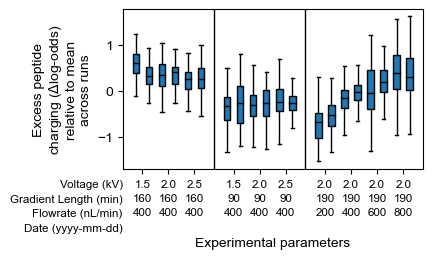

In [16]:
#%% Supplementary Figure 7

runs = lab_to_runs('Ours')

common_ions = sorted(intersection(*[ np.log(csd_all[run]).diff(axis=1).replace([-np.inf, np.inf], np.nan).stack().dropna().index for run in runs]))
aggregate_diff_log = np.array([ np.log(csd_all[run]).diff(axis=1).replace([-np.inf, np.inf], np.nan).stack().loc[common_ions] for run in runs ]).mean(0)
W = []
D = []
for run in runs:
    csd = csd_all[run]
    diff_log = np.log(csd).diff(axis=1).replace([-np.inf, np.inf], np.nan).stack().loc[common_ions]
    
    W.append((diff_log - aggregate_diff_log).mean())
    D.append(diff_log - aggregate_diff_log)
D = np.array(D)


group_counts = [6,6,8]
temp = np.cumsum(np.array([0] + group_counts) + 1)
dividers = temp[1:-1] - 1
positions = np.array(list(itertools.chain.from_iterable(list(range(i,j-1)) for i,j in zip(temp, temp[1:]))))


linespacing = 1.5

figsize = (6, 4)
axsize = (3,1.6)
position = compute_axes_position(figsize, axsize, right=0.5, bottom=1, coords='margin')

plt.figure(figsize=figsize)
plt.gcf().add_axes(position)

boxplot = plt.boxplot(D.T, showfliers=False, vert=True, positions=positions, patch_artist=True)
for median in boxplot['medians']:
    median.set_color('k')
for patch in boxplot['boxes']:
    patch.set_facecolor('C0')
    plt.setp(patch, facecolor='C0')


plt.ylabel('Excess peptide\ncharging ($\Delta$log-odds)\nrelative to mean\nacross runs')
plt.xticks(ticks=[])
for divider in dividers:
    plt.gca().axvline(divider, color='k', linewidth=1)
plt.xlim([min(positions)-1, max(positions) + 1])


tick_fontsize = 'small'

voltages = ['1.5', '2.0', '2.5'] * 2 + ['2.0'] * 4
gradients = ['160']*3 + ['90'] *3 + ['190'] * 4
flowrates = ['400'] * 6 + ['200','400','600','800']
dates = [''] * 20
xticklabels = ['\n'.join(z) for z in zip(voltages, gradients, flowrates, dates)]
xticks = (positions[1:] + positions[:-1])/2
xticks = xticks[::2]
plt.xticks(ticks=xticks, labels=xticklabels, linespacing=linespacing, fontsize=tick_fontsize)
plt.ylim([-1.7, 1.77])


points = compute_yticklabel_annotation_points(0, fontsize=tick_fontsize, linespacing=linespacing)
plt.annotate('Voltage (kV)', (0.00, points), xycoords='axes points', linespacing=linespacing, va='baseline', ha='right', fontsize=tick_fontsize)
points = compute_yticklabel_annotation_points(1, fontsize=tick_fontsize, linespacing=linespacing)
plt.annotate('Gradient Length (min)', (0.00, points), xycoords='axes points', linespacing=linespacing, va='baseline', ha='right', fontsize=tick_fontsize)
points = compute_yticklabel_annotation_points(2, fontsize=tick_fontsize, linespacing=linespacing)
plt.annotate('Flowrate (nL/min)', (0.00, points), xycoords='axes points', linespacing=linespacing, va='baseline', ha='right', fontsize=tick_fontsize)
points = compute_yticklabel_annotation_points(3, fontsize=tick_fontsize, linespacing=linespacing)
plt.annotate('Date (yyyy-mm-dd)', (0.00, points), xycoords='axes points', linespacing=linespacing, va='baseline', ha='right', fontsize=tick_fontsize)
plt.xlabel('Experimental parameters')

plt.show()


# Section 5  <a name="section5"></a>
## Supplementary Figure 8 <a name="suppfig8"></a>

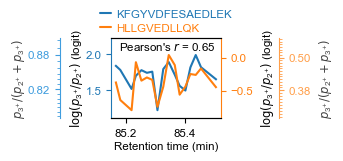

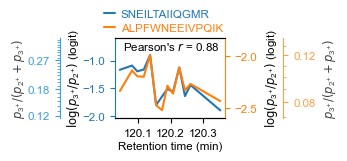

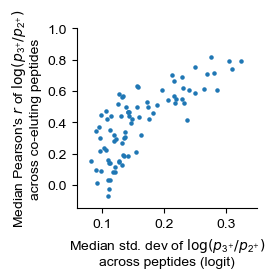

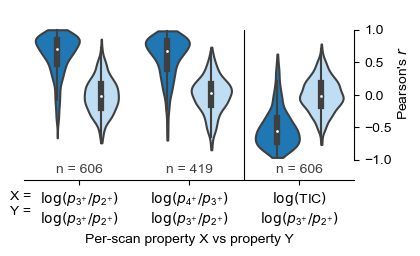

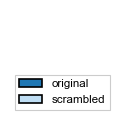

In [17]:
#%% Supplementary Figure 8

def create_charge_variation_dataset(run):
    extracted_intensity_df = extracted_intensity_df_all[run]
    
    granular_csi = extracted_intensity_df.dropna()[extracted_intensity_df.dropna().sum(1) > 0]
    granular_csd = granular_csi.div(granular_csi.sum(1), 0)
    
    log_odds_3on2 = (np.log(extracted_intensity_df[3].replace(0.0, np.nan)) - np.log(extracted_intensity_df[2].replace(0.0, np.nan))).dropna()
    log_odds_4on3 = (np.log(extracted_intensity_df[4].replace(0.0, np.nan)) - np.log(extracted_intensity_df[3].replace(0.0, np.nan))).dropna()

    return {
        'granular_csi' : granular_csi,
        'granular_csd' : granular_csd,
        'log_odds_3on2' : log_odds_3on2,
        'log_odds_4on3' : log_odds_4on3,
        }


def create_coelute_df(values_1, values_2, tic_array, min_length=10):
    np.random.seed(20220620)
    
    if values_2 is None:
        values_2 = values_1
    
    
    peptide_scan_pairs = values_1.rename_axis(index=['peptide', 'scan']).reset_index()[['peptide','scan']]
    peptide_to_scans_1 = peptide_scan_pairs.groupby('peptide')['scan'].apply(set)
    scan_to_peptides_1 = peptide_scan_pairs.groupby('scan')['peptide'].apply(list)
    peptide_scan_pairs = values_2.rename_axis(index=['peptide', 'scan']).reset_index()[['peptide','scan']]
    peptide_to_scans_2 = peptide_scan_pairs.groupby('peptide')['scan'].apply(set)
    scan_to_peptides_2 = peptide_scan_pairs.groupby('scan')['peptide'].apply(list)
    overlaps = set()
    for scan in set(scan_to_peptides_1.index) & set(scan_to_peptides_2.index):
        for peptide_1 in scan_to_peptides_1.loc[scan]:
            for peptide_2 in scan_to_peptides_2.loc[scan]:
                if peptide_1 == peptide_2:
                    continue
                weight = len(peptide_to_scans_1[peptide_1] & peptide_to_scans_2[peptide_2])
                overlaps.add((weight, (peptide_1, peptide_2)))    
    overlaps = sorted(list(overlaps))
    np.random.shuffle(overlaps)
    overlaps = sorted(overlaps, reverse=True, key=lambda x : x[0])

    
    visited_peptides = set()
    peptide_pairs = []
    lengths = []
    for length, (peptide_1, peptide_2) in overlaps:
        if peptide_1 not in visited_peptides and peptide_2 not in visited_peptides:
            visited_peptides.add(peptide_1)
            visited_peptides.add(peptide_2)
            peptide_pairs.append((peptide_1, peptide_2))
            lengths.append(length)
    peptide_pairs = np.array(peptide_pairs, dtype='object,object')
    lengths = np.array(lengths)
    
    peptide_pairs = peptide_pairs[lengths >= min_length]
    lengths = lengths[lengths >= min_length]
    
    
    np.random.seed(20220620)
    coelute_df = defaultdict(lambda : [])
    
    for peptide_1, peptide_2 in peptide_pairs:
        scans = sorted(peptide_to_scans_1[peptide_1] & peptide_to_scans_2[peptide_2])
        x = np.array(values_1[peptide_1][scans])
        y = np.array(values_2[peptide_2][scans])
        tic = tic_array[scans]
    
        coelute_df['peptide_1'].append(peptide_1)
        coelute_df['peptide_2'].append(peptide_2)
        coelute_df['scans'].append(scans)
        coelute_df['length'].append(len(scans))
        coelute_df['x'].append(x)
        coelute_df['y'].append(y)
        coelute_df['tic'].append(tic)
        
        
        for case in [
                'default',
                'shuffled',
                'pep2log10tic',
                'pep2log10tic_shuffled',
                ]:

            x = coelute_df['x'][-1]
            y = coelute_df['y'][-1]
            tic = coelute_df['tic'][-1]
    
            if case == 'default':
                prefix = 'pep2pep_'
                x = x
                y = y
            elif case == 'shuffled':
                prefix = 'pep2pep_' + case + '_'
                x = x
                y = y[np.random.permutation(len(y))]
            elif case == 'pep2log10tic':
                prefix = 'pep2log10tic_'
                x = x
                y = np.log10(tic)
            elif case == 'pep2log10tic_shuffled':
                prefix = 'pep2log10tic_shuffled_'
                x = x
                y = np.log10(tic)
                y = y[np.random.permutation(len(y))]
            else:
                None
                
            result = stats.linregress(x, y)    
            
            coelute_df[prefix + 'corrcoef'].append(np.corrcoef(x,y)[0,1])
            coelute_df[prefix + 'slope'].append(result.slope)
            coelute_df[prefix + 'intercept'].append(result.intercept)
            coelute_df[prefix + 'rvalue'].append(result.rvalue)
            coelute_df[prefix + 'pvalue'].append(result.pvalue)
            
    coelute_df = pd.DataFrame(coelute_df)
    return coelute_df



runs_ = lab_to_runs('Ours') + lab_to_runs('Confetti') + lab_to_runs('Meier')
log_odds_3on2_all = {}
log_odds_4on3_all = {}

for run in runs_:
    output = create_charge_variation_dataset(run)
    log_odds_3on2_all[run] = output['log_odds_3on2']
    log_odds_4on3_all[run] = output['log_odds_4on3']


@functools.lru_cache(512)
def create_coelute_df_helper(run, which_log_odds_1, which_log_odds_2=None):
        
    log_odds_3on2 = log_odds_3on2_all[run]
    log_odds_4on3 = log_odds_4on3_all[run] 
    tic_array = tic_array_all[run]
    
    if not which_log_odds_2:
        which_log_odds_2 = which_log_odds_1

    if which_log_odds_1 == '3on2':
        log_odds_1 = log_odds_3on2
    elif which_log_odds_1 == '4on3':
        log_odds_1 = log_odds_4on3
    else:
        raise Exception('which_log_odds_1 must be 3on2 or 4on3.')
        
    if which_log_odds_2 == '3on2':
        log_odds_2 = log_odds_3on2
    elif which_log_odds_2 == '4on3':
        log_odds_2 = log_odds_4on3
    else:
        raise Exception('which_log_odds_1 must be 3on2 or 4on3.')
    coelute_df = create_coelute_df(log_odds_1, log_odds_2, tic_array)
    return coelute_df



run = '20210420_MJ_LFQ_Hela_standard_gradient_long_Voltage_2p5_01'


which_log_odds_1 = '3on2'
which_log_odds_2 = '3on2'
coelute_df = create_coelute_df_helper(run, which_log_odds_1, which_log_odds_2)

rt_array = rt_array_all[run]
fixed_modifications = fixed_modifications_all[run]

def plot_example_peptides(peptide_1, peptide_2):
    
    idx = coelute_df.index[(coelute_df['peptide_1'] == peptide_1) & (coelute_df['peptide_2'] == peptide_2)][0]
    
    for aa, mod_aa in fixed_modifications.items():
        peptide_1 = peptide_1.replace(mod_aa, aa)
        peptide_2 = peptide_2.replace(mod_aa, aa)
    
    scans, x, y = coelute_df.iloc[idx][['scans', 'x', 'y']]
    t = rt_array[scans]
    xlim = margined([min(x), max(x)], [0.15, 0.30])
    ylim = margined([min(y), max(y)], [0.15, 0.30])
    
    major_tick_spacer = 0.5
    
    xticks = np.arange(np.ceil( xlim[0] / major_tick_spacer), np.floor( xlim[1] / major_tick_spacer)+ 1) * major_tick_spacer
    yticks = np.arange(np.ceil( ylim[0] / major_tick_spacer), np.floor( ylim[1] / major_tick_spacer)+ 1) * major_tick_spacer
    
    fontsize = 'small'
    color_1 = 'C0'
    color_2 = 'C1'
    
    figsize = (4,4)
    axsize = (1.1, 0.8)
    plt.figure(figsize=figsize)
    position = compute_axes_position(figsize, axsize, top=2, left=1.5, coords='margin')
    plt.gcf().add_axes(position)
    plt.plot(t,x, color_1)
    plt.xlabel('Retention time (min)', fontsize=fontsize, labelpad=2)
    plt.xticks(fontsize=fontsize)
    plt.annotate(f' Pearson\'s $r$ = {coelute_df.loc[idx]["pep2pep_corrcoef"]:.2f}', (axsize[0]/2 * 72, axsize[1] * 72 - 6), xycoords='axes points', ha='center', va='center', fontsize=fontsize)
    
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['left'].set_color(color_1)
    plt.ylim(xlim)
    plt.yticks(xticks)
    plt.gca().tick_params(axis='y', which='both', colors=color_1)
    plt.yticks(fontsize=fontsize)
    plt.ylabel('$\log(p_{\mathdefault{3}^{+}} / p_{\mathdefault{2}^{+}})$' + ' (logit)',
                fontsize=fontsize,
                va='baseline',
                )
    plt.twinx()
    plt.plot(t,y,color_2)
    plt.gca().spines['left'].set_visible(False)
    plt.gca().spines['right'].set_color(color_2)
    plt.ylim(ylim)
    plt.yticks(yticks)
    plt.gca().tick_params(axis='y', colors=color_2)
    plt.yticks(fontsize=fontsize)
    plt.ylabel('$\log(p_{\mathdefault{3}^{+}} / p_{\mathdefault{2}^{+}})$' + ' (logit)',
                fontsize=fontsize,
                )
    left_outward = 40
    if xlim[0] > 0:
        left_outward = 37
    
    right_outward = 42
    if ylim[0] > 0:
        right_outward = 39
    
    height_1 = 18
    height_2 = 8
    text_start = 4
    
    plt.annotate(peptide_1, (text_start, axsize[1] * 72 + height_1), xycoords='axes points', color=color_1, fontsize=fontsize, va='center_baseline')
    plt.annotate(peptide_2, (text_start, axsize[1] * 72 + height_2), xycoords='axes points', color=color_2, fontsize=fontsize, va='center_baseline')
    plt.gcf().add_artist(
        mpl.lines.Line2D(
            [-8/72-4/72 + text_start/72, -4/72 + text_start/72], [height_1/72, height_1/72],
            linewidth=1.5,
            solid_capstyle = 'round',
            color=color_1,
            transform=plt.gcf().dpi_scale_trans + mpl.transforms.ScaledTranslation(0,1,plt.gca().transAxes)
            )
        )
    plt.gcf().add_artist(
        mpl.lines.Line2D(
            [-8/72-4/72 + text_start/72, -4/72 + text_start/72], [height_2/72, height_2/72],
            linewidth=1.5,
            solid_capstyle = 'round',
            color=color_2,
            transform=plt.gcf().dpi_scale_trans + mpl.transforms.ScaledTranslation(0,1,plt.gca().transAxes)
            )
        )
    
    lighten_amount = 0.75
    color_1 = lighten_color(color_1, lighten_amount)
    color_2 = lighten_color(color_2, lighten_amount)
    
    plt.gcf().add_axes(position)
    plt.gca().patch.set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['bottom'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['left'].set_color(color_1)
    plt.gca().spines['left'].set_position(('outward', left_outward))
    plt.yticks(fontsize=fontsize)
    plt.xticks([])
    
    minor_tick_spacings = 0.01
    sigmoid_xticks = np.round(sigmoid(xticks) / minor_tick_spacings) * minor_tick_spacings
    
    sigmoid_minor_xticks = np.arange(
        np.floor(sigmoid(xlim[0]) / minor_tick_spacings) * minor_tick_spacings,
        (np.ceil(sigmoid(xlim[1]) / minor_tick_spacings) + 1) * minor_tick_spacings,
        minor_tick_spacings,
        )
    
    plt.ylim(xlim)
    plt.yticks(logit(sigmoid_xticks), labels=[ '%.2f' % a for a in sigmoid_xticks ])
    plt.gca().tick_params(axis='y', which='both', colors=color_1)
    plt.gca().yaxis.set_minor_locator(mpl.ticker.FixedLocator(
        logit(sigmoid_minor_xticks)
        ))
    
    plt.ylabel('$p_{\mathdefault{3}^{+}} / (p_{\mathdefault{2}^{+}} + p_{\mathdefault{3}^{+}})$',
                fontsize=fontsize,
                va = 'baseline',
                color = lighten_color('k', lighten_amount)
                )
    plt.twinx()
    
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['bottom'].set_visible(False)
    plt.gca().spines['left'].set_visible(False)
    plt.gca().spines['right'].set_color(color_2)
    plt.gca().spines['right'].set_position(('outward', right_outward))
    plt.yticks(fontsize=fontsize)

    minor_tick_spacings = 0.01
    sigmoid_yticks = np.round(sigmoid(yticks) / minor_tick_spacings) * minor_tick_spacings
    
    sigmoid_minor_yticks = np.arange(
        np.floor(sigmoid(ylim[0]) / minor_tick_spacings) * minor_tick_spacings,
        (np.ceil(sigmoid(xlim[1]) / minor_tick_spacings) + 1) * minor_tick_spacings,
        minor_tick_spacings,
        )
    
    plt.ylim(ylim)
    plt.yticks(logit(sigmoid_yticks), labels=[ '%.2f' % a for a in sigmoid_yticks ])
    plt.gca().tick_params(axis='y', which='both', colors=color_2)
    plt.gca().yaxis.set_minor_locator(mpl.ticker.FixedLocator(
        logit(sigmoid_minor_yticks)
        ))
    
    plt.ylabel('$p_{\mathdefault{3}^{+}} / (p_{\mathdefault{2}^{+}} + p_{\mathdefault{3}^{+}})$',
                fontsize=fontsize,
                color = lighten_color('k', lighten_amount)
                )
    plt.show()


peptide_1 = 'KFGYVDFESAEDLEK'
peptide_2 = 'HLLGVEDLLQK'
plot_example_peptides(peptide_1, peptide_2)

peptide_1 = 'SNEILTAIIQGMR'
peptide_2 = 'ALPFWNEEIVPQIK'
plot_example_peptides(peptide_1, peptide_2)




runs_ = lab_to_runs('Ours') + lab_to_runs('Confetti') + lab_to_runs('Meier')
all_corr_across_runs = []
all_std_across_runs = []
labs = []
runs = []
for run in runs_:
    which_log_odds_1 = '3on2'
    which_log_odds_2 = '3on2'
    coelute_df = create_coelute_df_helper(run, which_log_odds_1, which_log_odds_2)
    if len(coelute_df) > 0:
        all_corr_across_runs.append(coelute_df['pep2pep_corrcoef'].to_numpy())
        all_std_across_runs.append(coelute_df.x.apply(np.std))
        labs.append(run_to_lab(run))
        runs.append(run)

corr = np.array(list(map(np.median, all_corr_across_runs)))
sigma_eta = np.array(list(map(np.median, all_std_across_runs)))

labs = np.array(labs)
runs = np.array(runs)
num_datapoints = np.array(list(map(len, all_corr_across_runs)))
var = sigma_eta**2

fontsize = 'medium'
keep_idx = num_datapoints > 15

figsize = (4, 4)
axsize = (1.8, 1.8)
plt.figure(figsize=figsize)
position = compute_axes_position(figsize, axsize, bottom=1, left=1, coords='margin')
plt.gcf().add_axes(position)
plt.scatter(sigma_eta[keep_idx], corr[keep_idx], c='w', s=15)
plt.scatter(sigma_eta[keep_idx], corr[keep_idx], s=5)

plt.xlabel('Median std. dev of $\log(p_{\mathdefault{3}^{+}} / p_{\mathdefault{2}^{+}})$\nacross peptides (logit)', fontsize=fontsize)
plt.ylabel('Median Pearson\'s $r$ of $\log(p_{\mathdefault{3}^{+}} / p_{\mathdefault{2}^{+}})$\nacross co-eluting peptides', fontsize=fontsize)

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.ylim([-0.15,1])
plt.yticks([0,0.2,0.4,0.6,0.8, 1.0])
plt.xlim([0.06, 0.35])
plt.xticks([0.1,0.2,0.3])

xmin, xmax = plt.gca().get_xlim()
ymin, ymax = plt.gca().get_ylim()
plt.show()


run = '20210420_MJ_LFQ_Hela_standard_gradient_long_Voltage_2p5_01'

which_log_odds_1 = '3on2'
which_log_odds_2 = '3on2'
coelute_df = create_coelute_df_helper(run, which_log_odds_1, which_log_odds_2)
A1 = coelute_df['pep2pep_corrcoef']
A2 = coelute_df['pep2pep_shuffled_corrcoef']
C1 = coelute_df['pep2log10tic_corrcoef']
C2 = coelute_df['pep2log10tic_shuffled_corrcoef']

which_log_odds_1 = '3on2'
which_log_odds_2 = '4on3'
coelute_df = create_coelute_df_helper(run, which_log_odds_1, which_log_odds_2)
B1 = coelute_df['pep2pep_corrcoef']
B2 = coelute_df['pep2pep_shuffled_corrcoef']

fontsize = 'medium'

axsize = (3.3, 1.7)
figsize = (7,5)

position = compute_axes_position(figsize, axsize, bottom=1, right = 1, coords='margin')
plt.figure(figsize = figsize)
plt.gcf().add_axes(position)

df = []
for i, arr in enumerate([A1, A2, B1, B2, C1, C2]):
    df.extend(list(zip(arr, [i // 2]*len(arr), [i % 2]*len(arr))))
df = pd.DataFrame(df, columns=['corr', 'type', 'hue'])
g = sns.violinplot(data=df, x='type', y='corr', hue='hue', orient='vertical', cut=0)

left_kwargs = {
    'facecolor' : sns.color_palette()[0],
    }

right_kwargs = {
    'facecolor' : lighten_color(sns.color_palette()[0], 0.25),
    }

kwargs = iter([ left_kwargs, right_kwargs ]*3)

for poly in [ item for item in plt.gca().get_children() if isinstance(item, mpl.collections.PolyCollection) ]:
    poly.set(**next(kwargs))

top_crop = 0.2
bottom_crop = 0.2
crop = top_crop + bottom_crop

plt.ylim(margined([-1,1], [ bottom_crop / crop * (1 / (1 - crop / axsize[1]) - 1), top_crop / crop * (1 / (1 - crop / axsize[1]) - 1)]))

color = '#404040'
min_y = plt.gca().get_ylim()[0]
plt.annotate(f'n = {len(A1)}', (0, (-1 + min_y)/2), xycoords='data', ha='center', va='center', fontsize=fontsize, color=color)
plt.annotate(f'n = {len(B1)}', (1, (-1 + min_y)/2), xycoords='data', ha='center', va='center', fontsize=fontsize, color=color)
plt.annotate(f'n = {len(C1)}', (2, (-1 + min_y)/2), xycoords='data', ha='center', va='center', fontsize=fontsize, color=color)
plt.gca().axvline(1.5, ymax = 1 - top_crop / axsize[1], color='k', linewidth=0.8)

plt.ylabel('Pearson\'s $r$', fontsize=fontsize, y = (0 - min_y) / (1 - min_y))
plt.xticks([0,1,2], labels=[
    '$\log(p_{\mathdefault{3}^{+}} / p_{\mathdefault{2}^{+}})$\n$\log(p_{\mathdefault{3}^{+}} / p_{\mathdefault{2}^{+}})$',
    '$\log(p_{\mathdefault{4}^{+}} / p_{\mathdefault{3}^{+}})$\n$\log(p_{\mathdefault{3}^{+}} / p_{\mathdefault{2}^{+}})$',
    '$\log($TIC$)$\n$\log(p_{\mathdefault{3}^{+}} / p_{\mathdefault{2}^{+}})$',
    ], fontsize=fontsize)
plt.xlabel('')
plt.legend([], [], frameon=False)

outward_points = 0

points = compute_yticklabel_annotation_points(0, fontsize=fontsize) - outward_points
plt.annotate('X =', (5, points), xycoords='axes points', va='baseline', ha='right', fontsize=fontsize)
points = compute_yticklabel_annotation_points(1, yticklabel_fontsize_to_pt = 0.76055, fontsize=fontsize) - outward_points
plt.annotate('Y =', (5,points), xycoords='axes points', va='baseline', ha='right', fontsize=fontsize)
plt.xlabel('Per-scan property X vs property Y', fontsize=fontsize)

plt.gca().yaxis.set_label_position('right')
plt.gca().yaxis.tick_right()
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['bottom'].set_position(('outward', outward_points))
plt.gca().spines['right'].set_bounds([-1,1])
plt.show()


figsize = (4,1)
axsize = (1, 1)
right_margin = 0.5
bottom_margin = 0.1
plt.figure(figsize=figsize)
position = compute_axes_position(figsize, axsize, bottom=bottom_margin, right=right_margin, coords='margin')
plt.gcf().add_axes(position)
plt.axis('off')
handles = []
patch_kwargs = {
    'linestyle' : '-',
    'edgecolor' : 'k',
    'linewidth' : 1.2,
    }

if 'hatch' in right_kwargs:
    right_kwargs['hatch'] += '/'


left_label = 'original'
right_label = 'scrambled'
handles.append(mpl.patches.Patch(label=left_label, **patch_kwargs, **left_kwargs))
handles.append(mpl.patches.Patch(label=right_label, **patch_kwargs, **right_kwargs))
leg = plt.legend(handles=handles, loc='lower right', ncol=1, framealpha=1, borderaxespad=0, handlelength=2, handleheight=0.7, fontsize='small')
leg.get_frame().set_facecolor('none')
leg.get_frame().set_boxstyle('Square', pad=0)
leg.get_frame().set_linewidth(0.8)
plt.show()